In [245]:
library(tidyverse)
library(caret)
library(lattice)
library(dygraphs)
library(cowplot)
library(ggthemr)
library(xts)

ggthemr::ggthemr("fresh")
options(repr.plot.width=12, repr.plot.height=5)

Warning message:
“New theme missing the following elements: panel.grid, plot.tag, plot.tag.position”

_Note: All EDA done on training split only_

In [250]:
df_train = readRDS("df_train.RData")
df_val = readRDS("df_val.RData")

## What value do the zones add?

### For regression

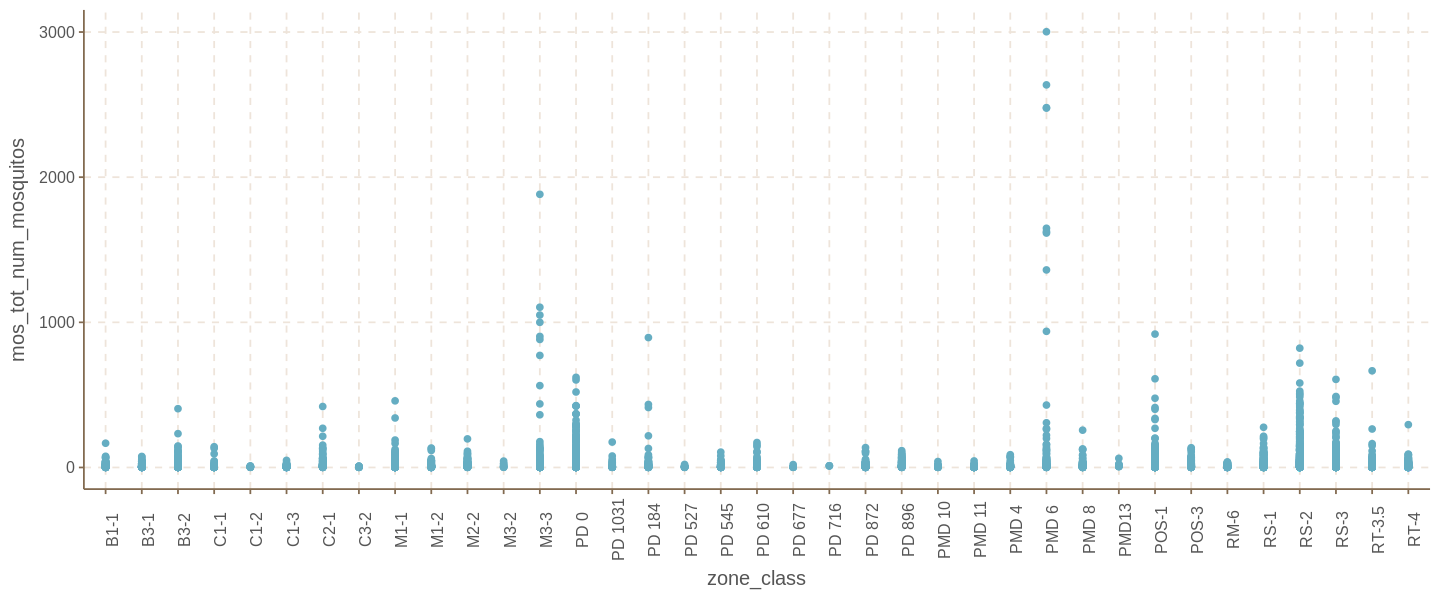

In [8]:
df_train %>% ggplot(aes(y=mos_tot_num_mosquitos,x=zone_class)) + geom_point() + 
    theme(axis.text.x = element_text(angle=90))

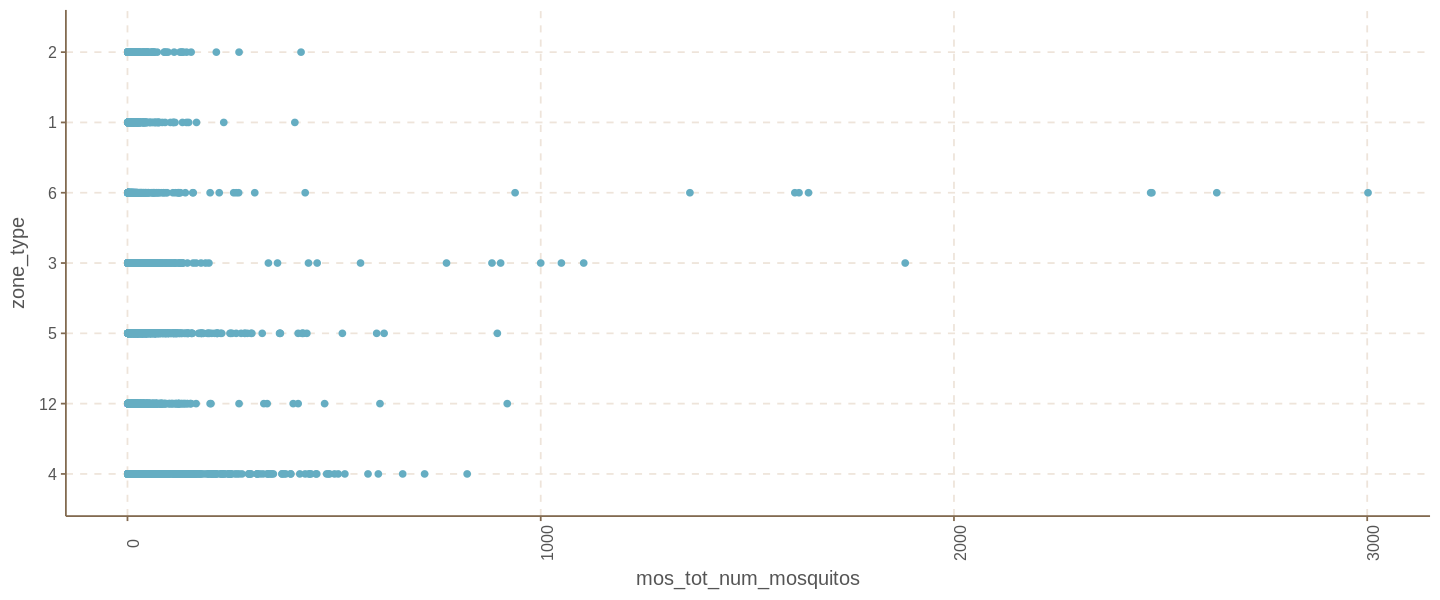

In [9]:
df_train %>% ggplot(aes(y=mos_tot_num_mosquitos,x=zone_type)) + geom_point() + 
    theme(axis.text.x = element_text(angle=90))+coord_flip()

## For classification

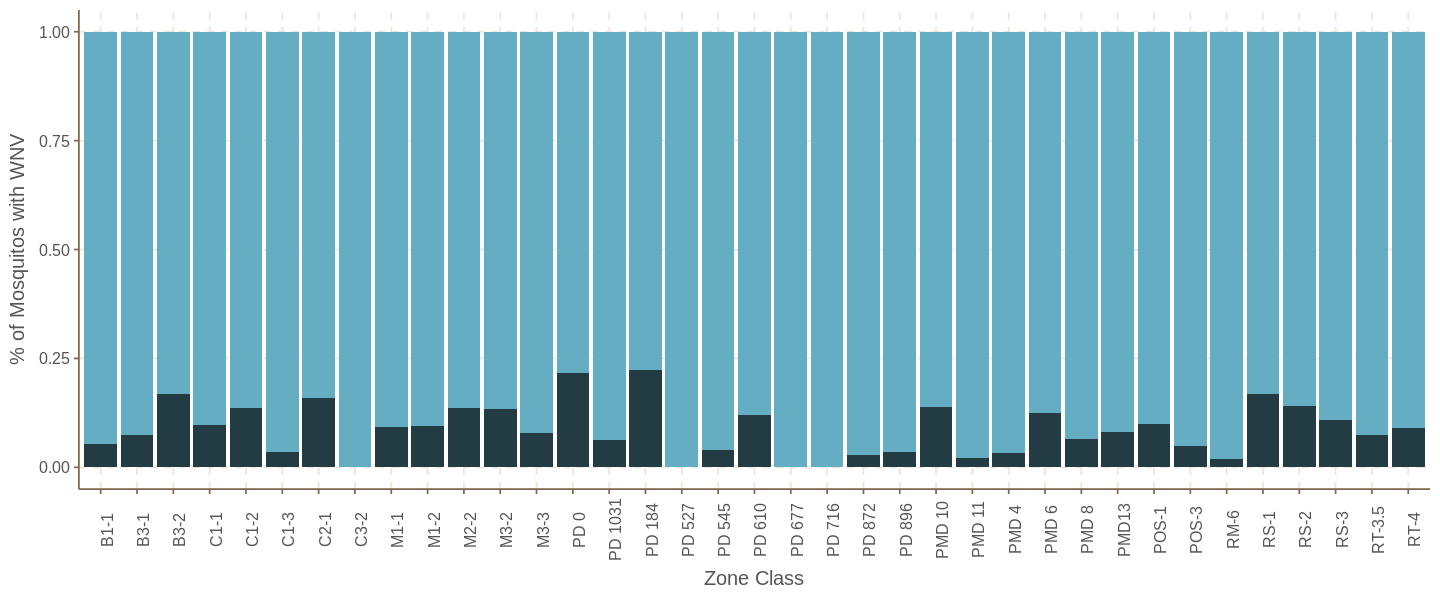

In [23]:
df_train %>% ggplot(aes(fill=mos_any_wnv_present,zone_class)) +
    geom_bar(position="fill")+theme(axis.text.x = element_text(angle=90))+
    theme(legend.position = "None")+
    labs(x="Zone Class", y="% of Mosquitos with WNV") -> p2
p2

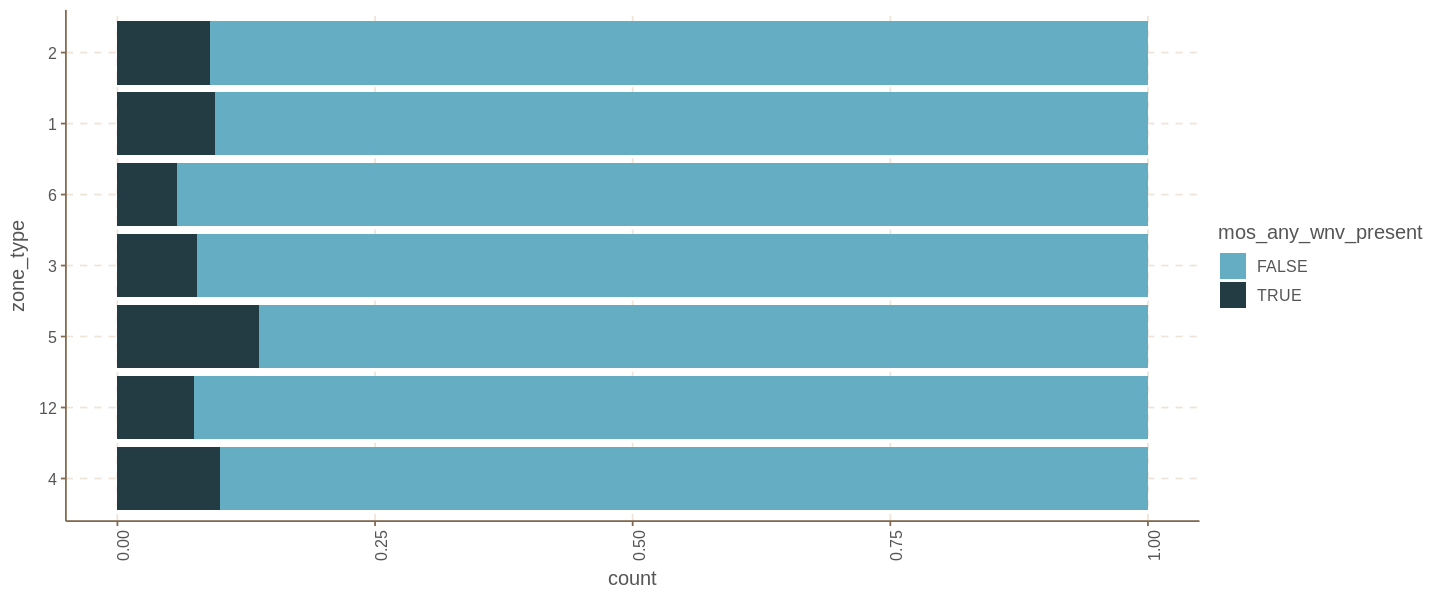

In [11]:
df_train %>% ggplot(aes(fill=mos_any_wnv_present,zone_type)) +
    geom_bar(position="fill")+theme(axis.text.x = element_text(angle=90))+coord_flip()

### Where are the different zones located?

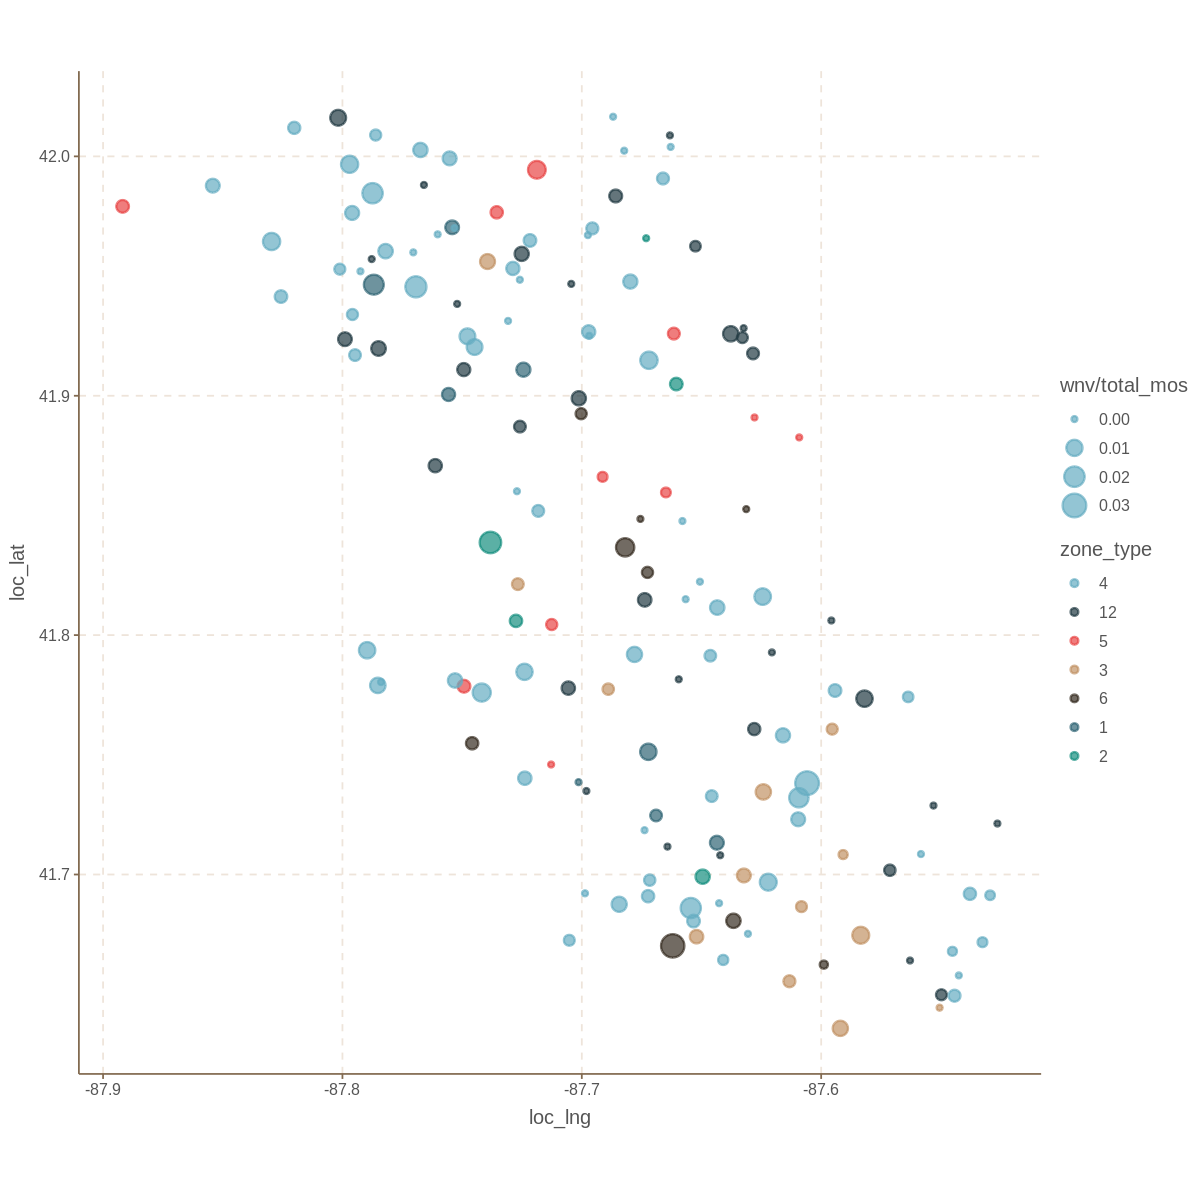

In [189]:
options(repr.plot.width=10, repr.plot.height=10)
df_train %>%
    group_by(loc_lng,loc_lat,zone_type) %>%
    summarize(total_mos = sum(mos_tot_num_mosquitos),
             wnv = sum(mos_any_wnv_present)) %>%
    ggplot(aes(loc_lng,loc_lat,color=zone_type,size=wnv/total_mos))+
    geom_jitter(width = 0.01, height = 0.01, alpha = 0.7, stroke = 1)+
    coord_equal()
options(repr.plot.width=12, repr.plot.height=5)

What's going on with that dark red square on the top left?

And note the large sized black triangles at the bottom right too. Interesting.

# Do the trap variables offer anything?

In [13]:
df_train %>% select(starts_with("trap")) %>% head()

trap_trap_name trap_satellite_ind trap_trap_type
1 T002           FALSE              GRAVID        
2 T007           FALSE              CDC           
3 T015           FALSE              GRAVID        
4 T045           FALSE              GRAVID        
5 T046           FALSE              CDC           
6 T048           FALSE              GRAVID

## For regression?

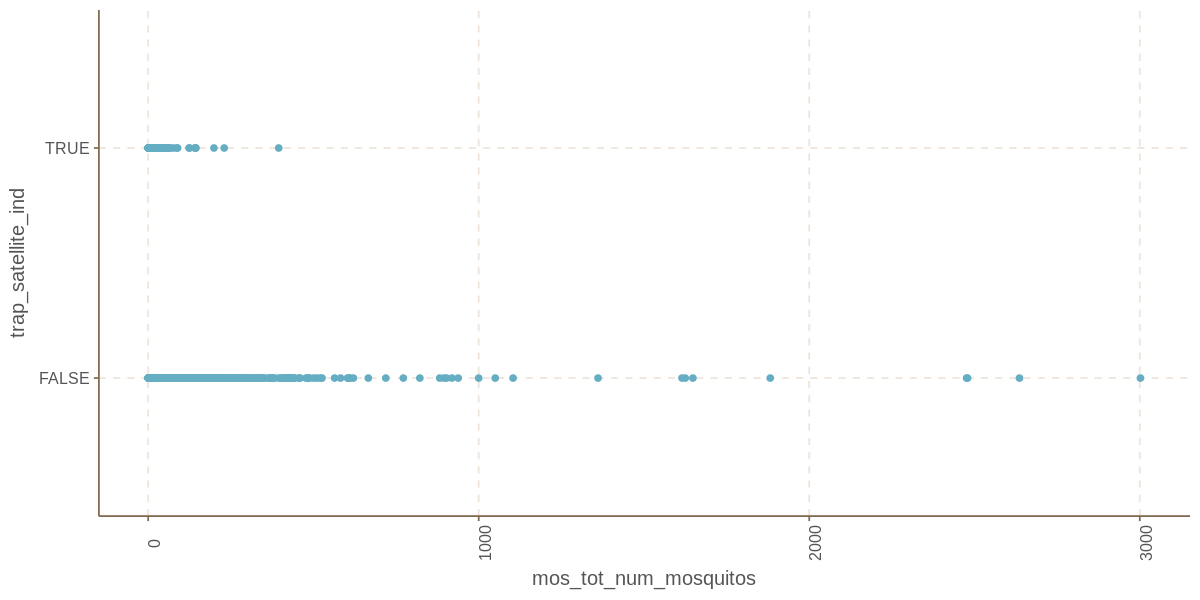

In [14]:
options(repr.plot.width=10, repr.plot.height=5)
df_train %>% ggplot(aes(y=mos_tot_num_mosquitos,x=trap_satellite_ind)) + geom_point() + 
    theme(axis.text.x = element_text(angle=90)) + coord_flip()

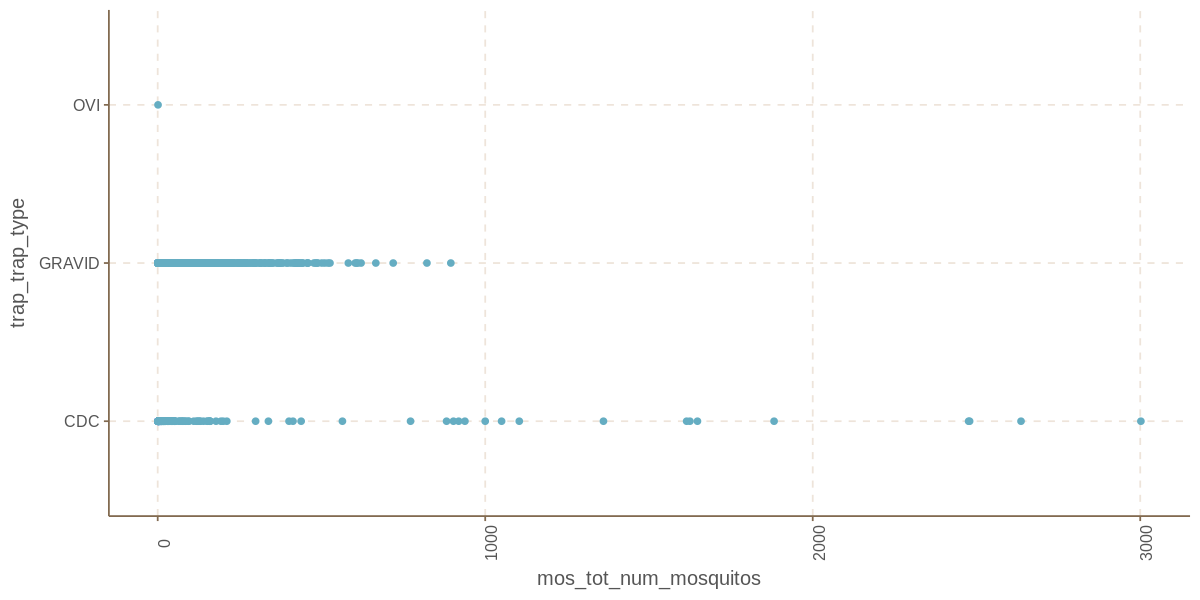

In [15]:
df_train %>% ggplot(aes(y=mos_tot_num_mosquitos,x=trap_trap_type)) + geom_point() + 
    theme(axis.text.x = element_text(angle=90)) + coord_flip()

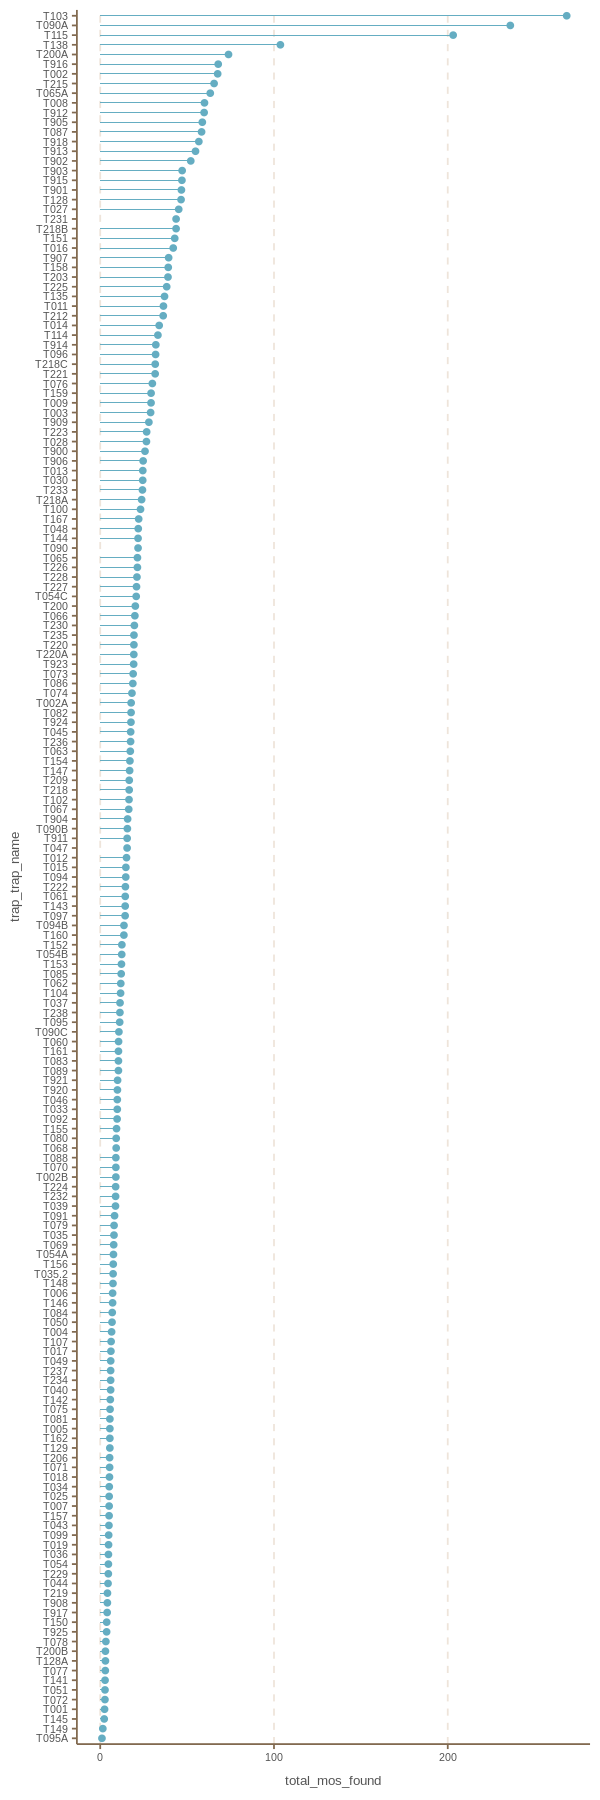

In [16]:
options(repr.plot.width=5, repr.plot.height=15)
df_train %>% 
    select(mos_tot_num_mosquitos, trap_trap_name) %>%
    group_by(trap_trap_name) %>%
    summarize(total_mos_found = sum(mos_tot_num_mosquitos)/length(trap_trap_name)) %>%
    mutate(trap_trap_name = factor(trap_trap_name,levels = trap_trap_name[order(.$total_mos_found)])) %>%
    ggplot(aes(y=total_mos_found,x=trap_trap_name)) +
    geom_point()+geom_col(width = .1)+theme(text = element_text(size=8))+
    coord_flip() + theme(panel.grid.major.y = element_blank())

## For classification?

Why is that one trap "T090A" 100% infected?

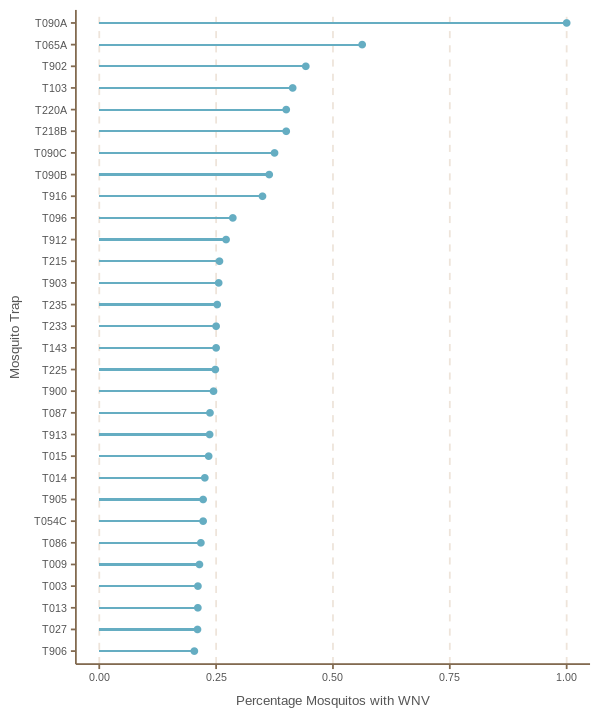

In [30]:
options(repr.plot.width=5, repr.plot.height=6)
df_train %>% 
    select(mos_any_wnv_present, trap_trap_name) %>%
    group_by(trap_trap_name) %>%
    summarize(pct_wnv_found = sum(mos_any_wnv_present)/length(trap_trap_name)) %>%
    filter(pct_wnv_found > .2) %>%
    mutate(trap_trap_name = factor(trap_trap_name,levels = trap_trap_name[order(.$pct_wnv_found)])) %>%
    ggplot(aes(y=pct_wnv_found,x=trap_trap_name)) +
    geom_point()+geom_col(width = .1)+theme(text = element_text(size=8))+
    coord_flip() + theme(panel.grid.major.y = element_blank()) + 
    labs(x="Mosquito Trap",y="Percentage Mosquitos with WNV") -> p3
p3

The satellite variable adds no information

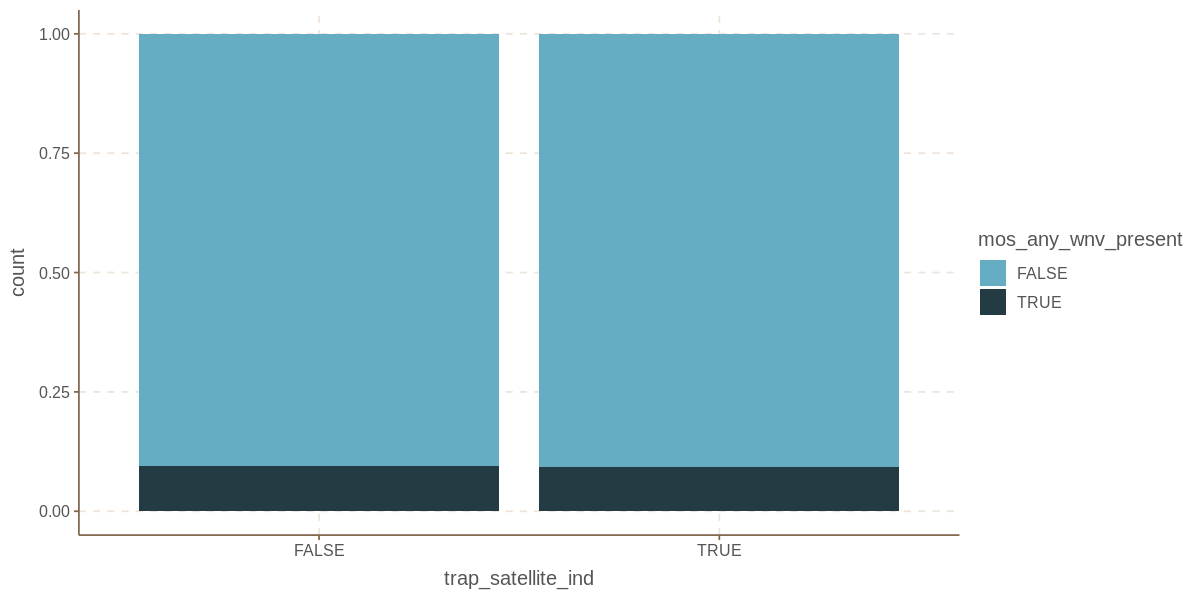

In [18]:
options(repr.plot.width=10, repr.plot.height=5)
df_train %>%
    ggplot(aes(fill=mos_any_wnv_present,trap_satellite_ind))+
    geom_bar(position = "fill")

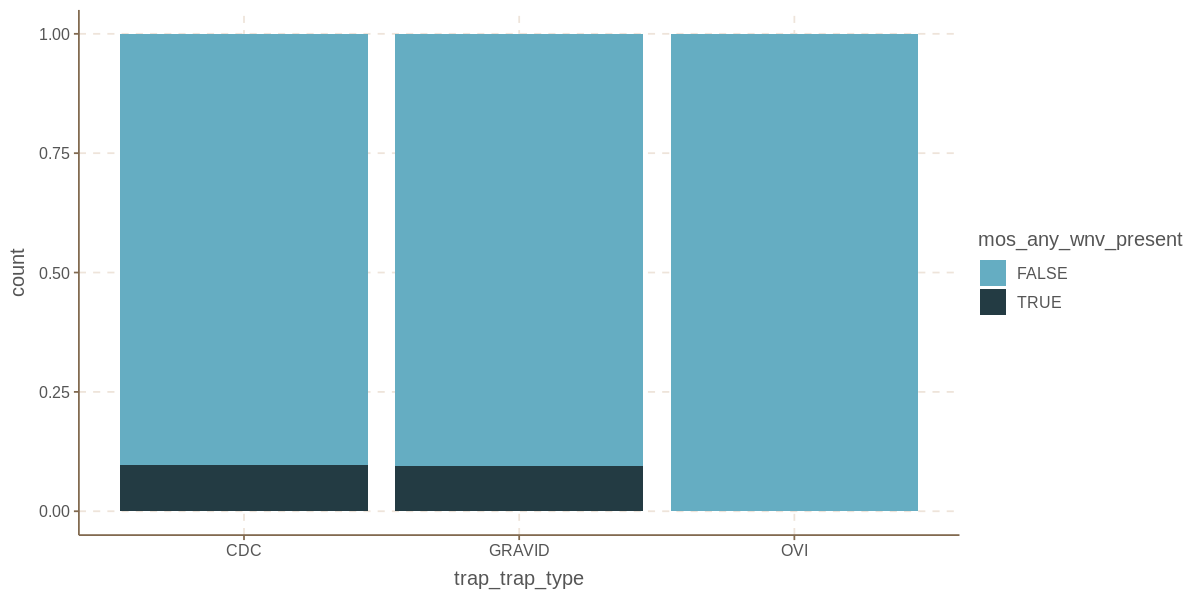

In [19]:
df_train %>%
    ggplot(aes(fill=mos_any_wnv_present,trap_trap_type))+
    geom_bar(position = "fill")

# What do the location variables offer?

In [3]:
df_loc = df_train %>% dplyr::select(starts_with("loc_"),
                                    "mos_any_wnv_present","mos_tot_num_mosquitos")

In [4]:
head(df_loc)

loc_lat  loc_lng   loc_lat_lng_src loc_zipcode loc_census_block_group_id
1 41.95630 -87.79752 CDPH            60634       170311701001             
2 41.95630 -87.79752 CDPH            60634       170311701001             
3 41.99549 -87.76961 CDPH            60646       170311201003             
4 41.97418 -87.82524 CDPH            60656       170311005005             
5 41.97418 -87.82524 CDPH            60656       170311005005             
6 41.92170 -87.66696 CDPH            60614       170318325001             
  loc_census_tract_id loc_community mos_any_wnv_present mos_tot_num_mosquitos
1 17031170100         DUNNING       FALSE               2                    
2 17031170100         DUNNING       FALSE               2                    
3 17031120100         FOREST GLEN   FALSE               1                    
4 17031100500         NORWOOD PARK  FALSE               5                    
5 17031100500         NORWOOD PARK  FALSE               5                    
6 17031832500         LINCOLN PARK  FALSE               2

## Lat Long Source

Lat Long source seems to have some predictive power

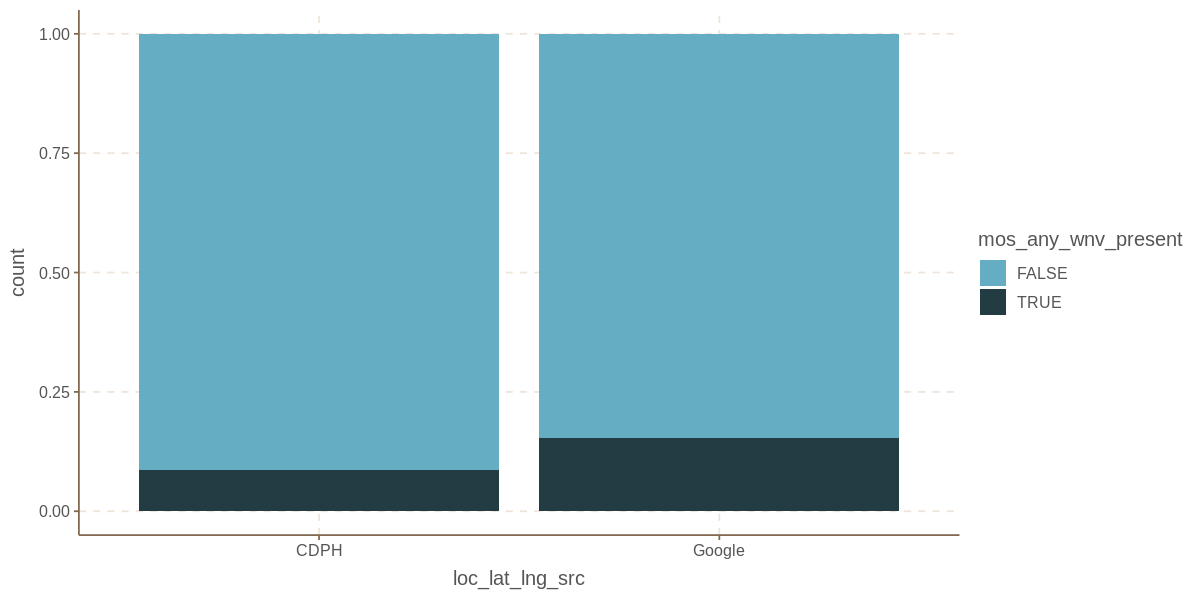

In [22]:
df_loc %>%
    ggplot(aes(fill=mos_any_wnv_present,loc_lat_lng_src))+
    geom_bar(position = "fill")

## Community

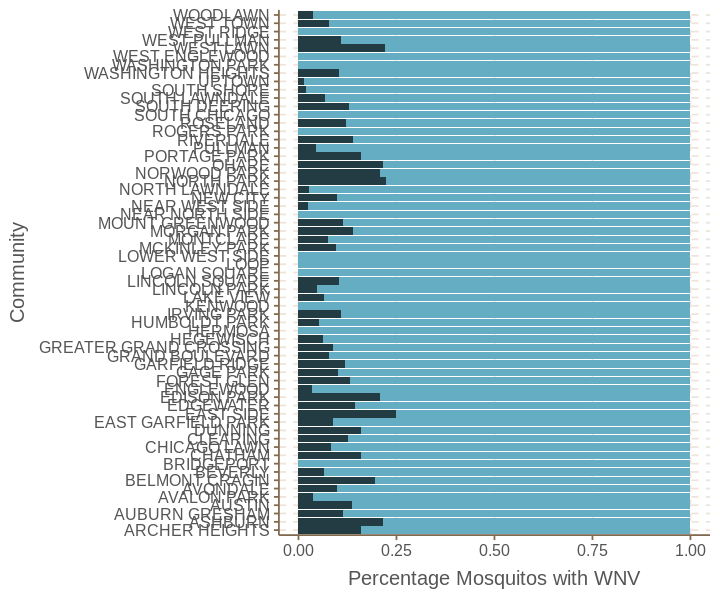

In [51]:
options(repr.plot.width=6, repr.plot.height=5)
p1 = df_loc %>%
    ggplot(aes(fill=mos_any_wnv_present,loc_community))+
    geom_bar(position = "fill") + coord_flip()+
    labs(x="Community",y="Percentage Mosquitos with WNV")+
    theme(legend.position = "None")
p1

Same plot as before, but color coded by Community

In [13]:
options(repr.plot.width=10, repr.plot.height=10)
color_pal = sample(colors(distinct = T),70,replace = F)
cust_theme = define_palette(swatch = color_pal, gradient = c(head(color_pal,1),tail(color_pal,1)))

Warning message:
“New theme missing the following elements: panel.grid, plot.tag, plot.tag.position”

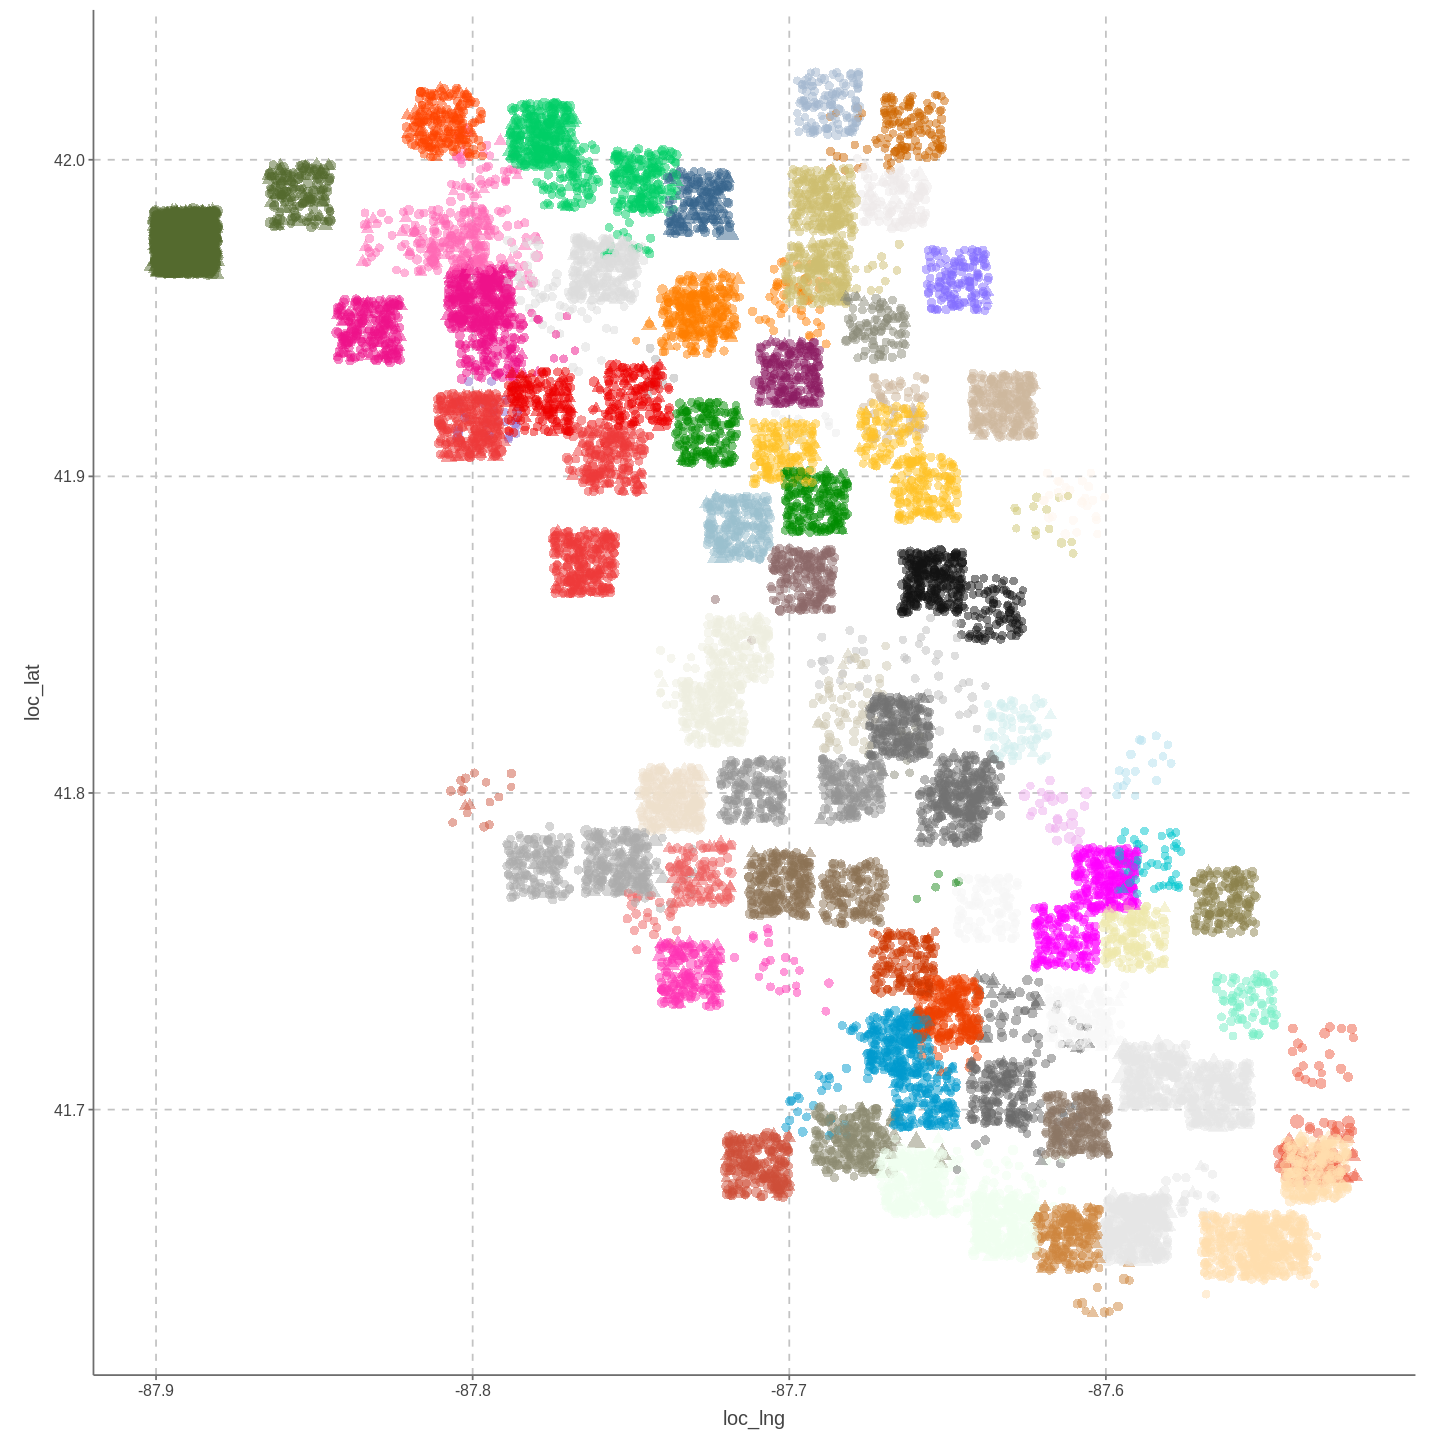

In [14]:
ggthemr(cust_theme)
options(repr.plot.width=12, repr.plot.height=12)
df_train %>%
    ggplot(aes(loc_lng,loc_lat,color=loc_community,shape=mos_any_wnv_present,size=mos_tot_num_mosquitos))+
    geom_jitter(width = 0.01, height = 0.01, alpha = 0.5, stroke=2)+
    coord_equal()+
    theme(legend.position = "none")

In [26]:
ggthemr("fresh")

Warning message:
“New theme missing the following elements: panel.grid, plot.tag, plot.tag.position”

## Block

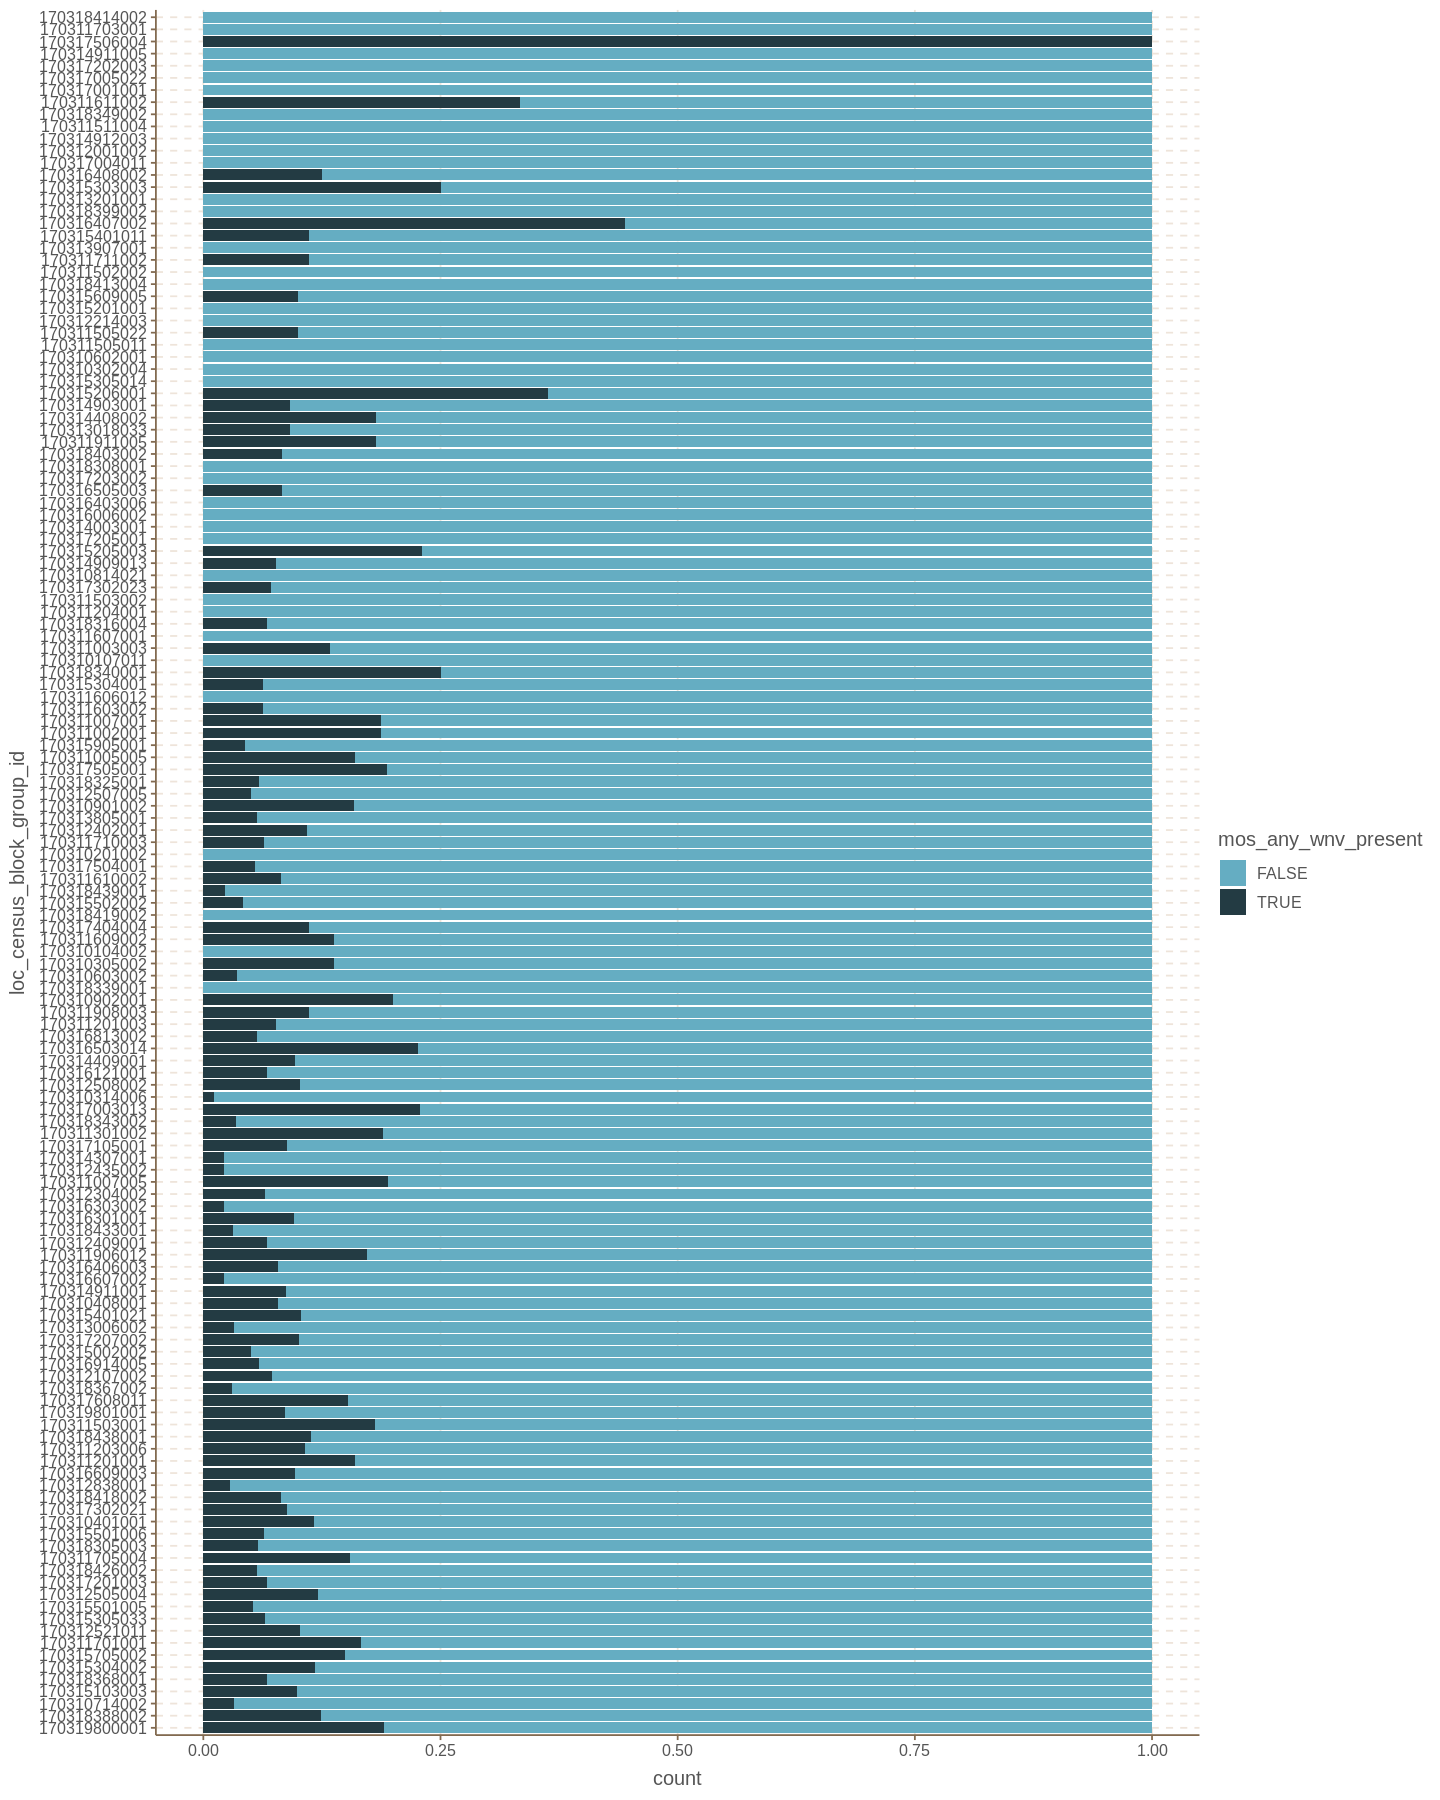

In [27]:
options(repr.plot.width=12, repr.plot.height=15)
df_loc %>%
    ggplot(aes(fill=mos_any_wnv_present,loc_census_block_group_id))+
    geom_bar(position = "fill") + coord_flip()

Zipcode certainly has predictive power. Some zipcodes are not affected at all.

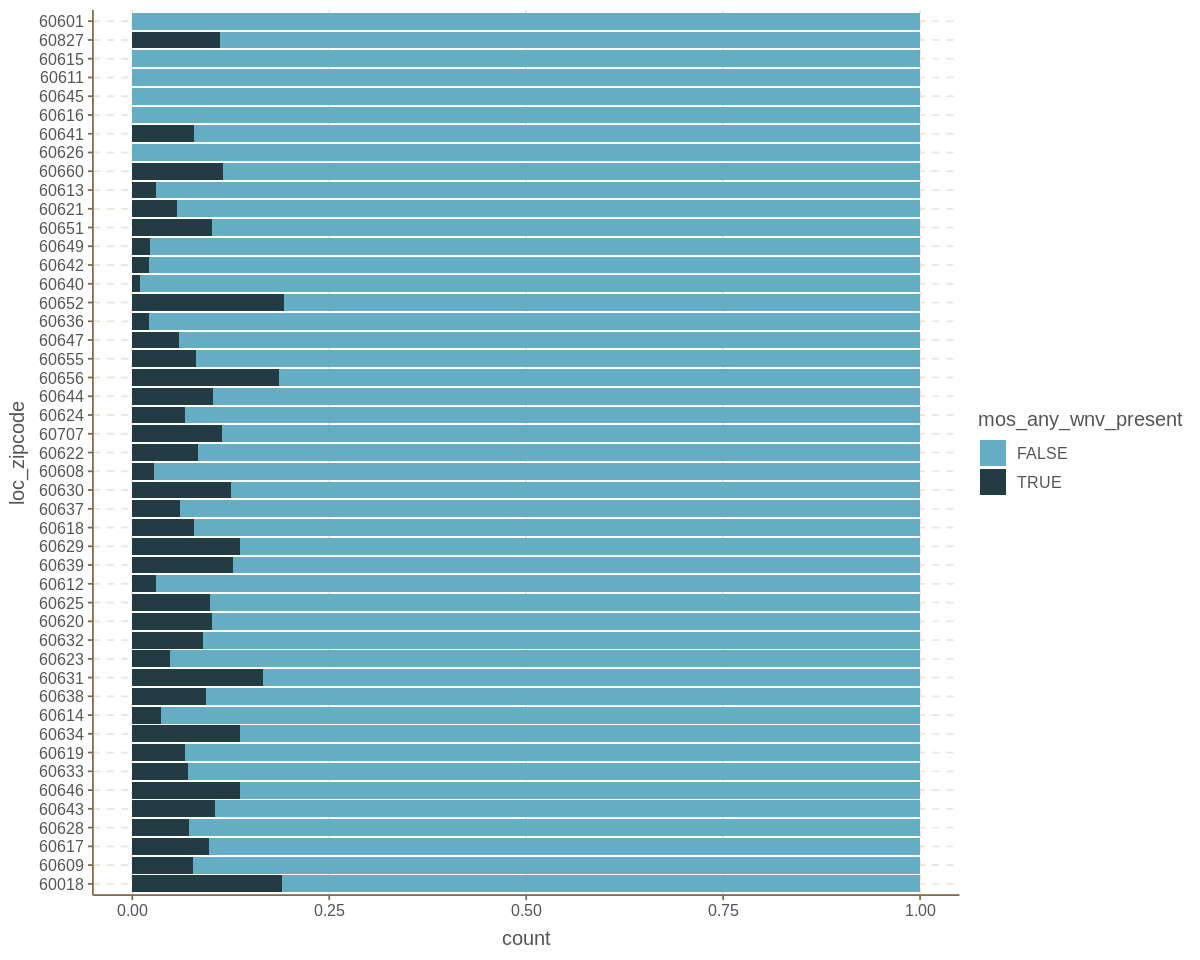

In [28]:
options(repr.plot.width=10, repr.plot.height=8)
df_loc %>%
    ggplot(aes(fill=mos_any_wnv_present,loc_zipcode))+
    geom_bar(position = "fill") + coord_flip()

How do the zipcodes with active WNV vary over time?

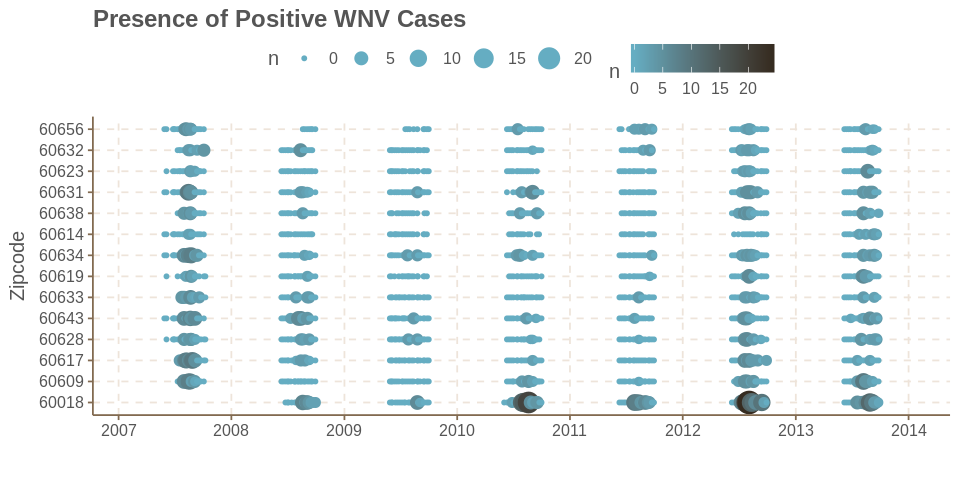

In [126]:
options(repr.plot.width=8, repr.plot.height=4)
df_train %>%
    group_by(t_date,loc_zipcode) %>%
    tally(mos_any_wnv_present) %>%
    filter(loc_zipcode %in% c(60018,60609,60617,60628,60643,60656,60633,60619,60634,60614,60638,60631,60623,60632)) %>%
    ggplot()+
    geom_point(aes(x=t_date,size=n,y = loc_zipcode, color = n))+
    theme(legend.position = "top")+
#    scale_size_continuous(trans = "log")+
    scale_x_date(date_breaks = "1 year", date_labels = "%Y",expand = c(.1,0))+
    labs(title = "Presence of Positive WNV Cases",
        x = "", y="Zipcode")

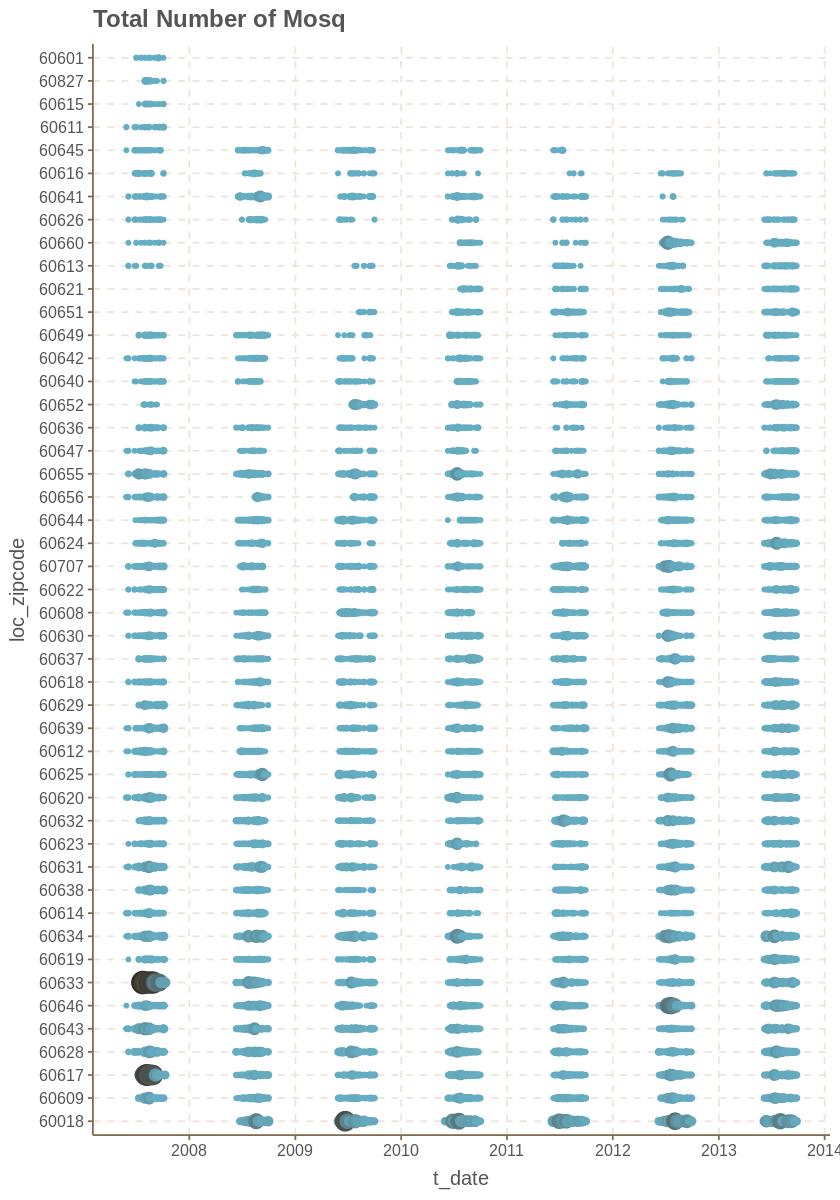

In [30]:
options(repr.plot.width=7, repr.plot.height=10)
df_train %>%
    group_by(t_date,loc_zipcode) %>%
    tally(mos_tot_num_mosquitos) %>%
    ggplot()+
    geom_point(aes(x=t_date,size=n,y = loc_zipcode, color = n))+
    theme(legend.position = "none")+
    scale_x_date(date_breaks = "1 year", date_labels = "%Y")+
    labs(title = "Total Number of Mosq")

Putting both the count of mosq & the # of cases together: A bit complex plot; yet something interesting -- in some cases, the # of mosq is quite high, yet, not as many cases.

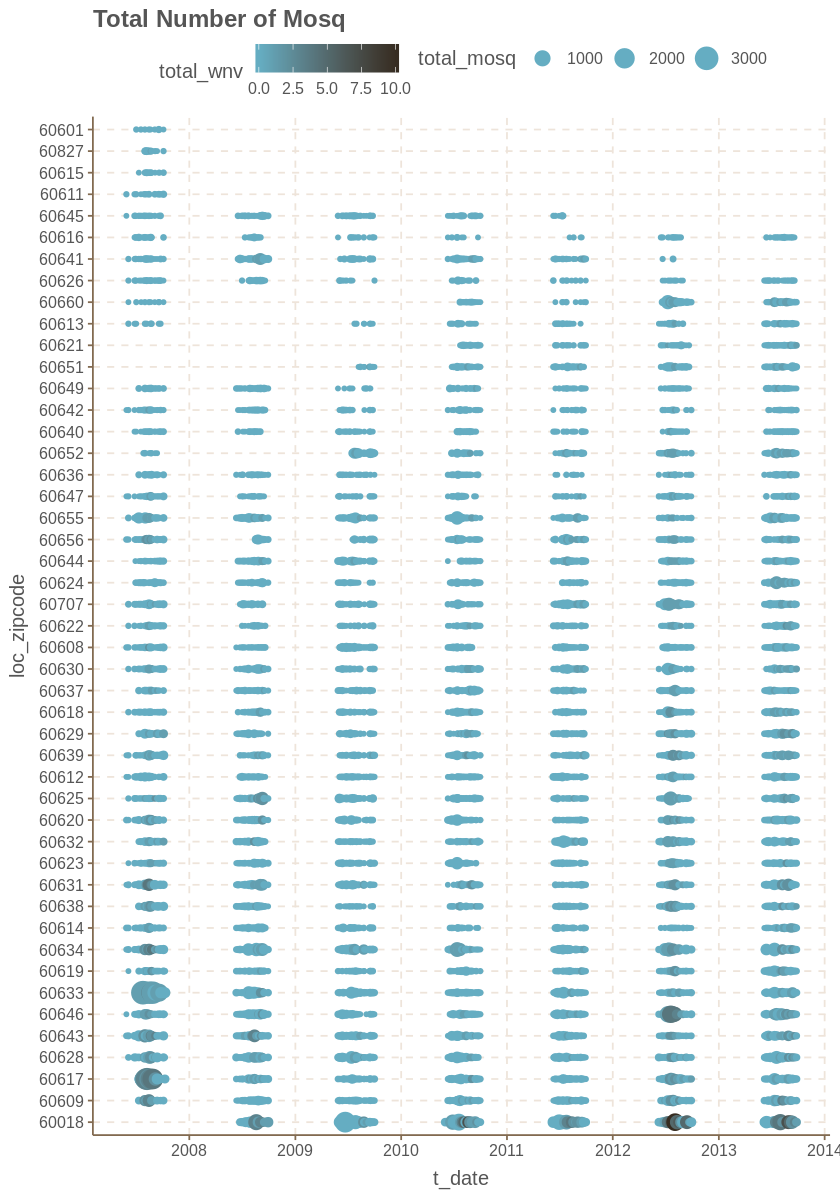

In [31]:
options(repr.plot.width=7, repr.plot.height=10)
df_train %>%
    group_by(t_date,loc_zipcode) %>%
    summarize(total_mosq = sum(mos_tot_num_mosquitos),total_wnv = sum(mos_any_wnv_present)) %>%
    ggplot()+
    geom_point(aes(x=t_date,size=total_mosq,y = loc_zipcode, color = total_wnv))+
    theme(legend.position = "top")+
    scale_x_date(date_breaks = "1 year", date_labels = "%Y")+
    labs(title = "Total Number of Mosq")

# Does SES offer any value?

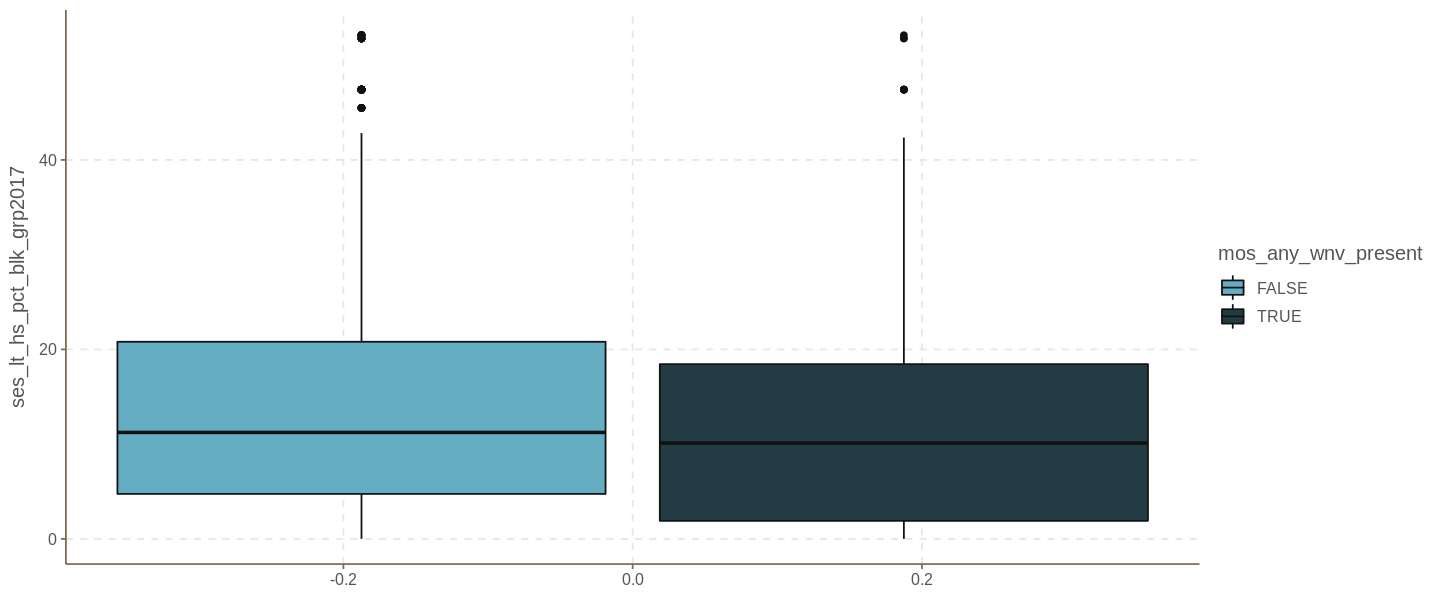

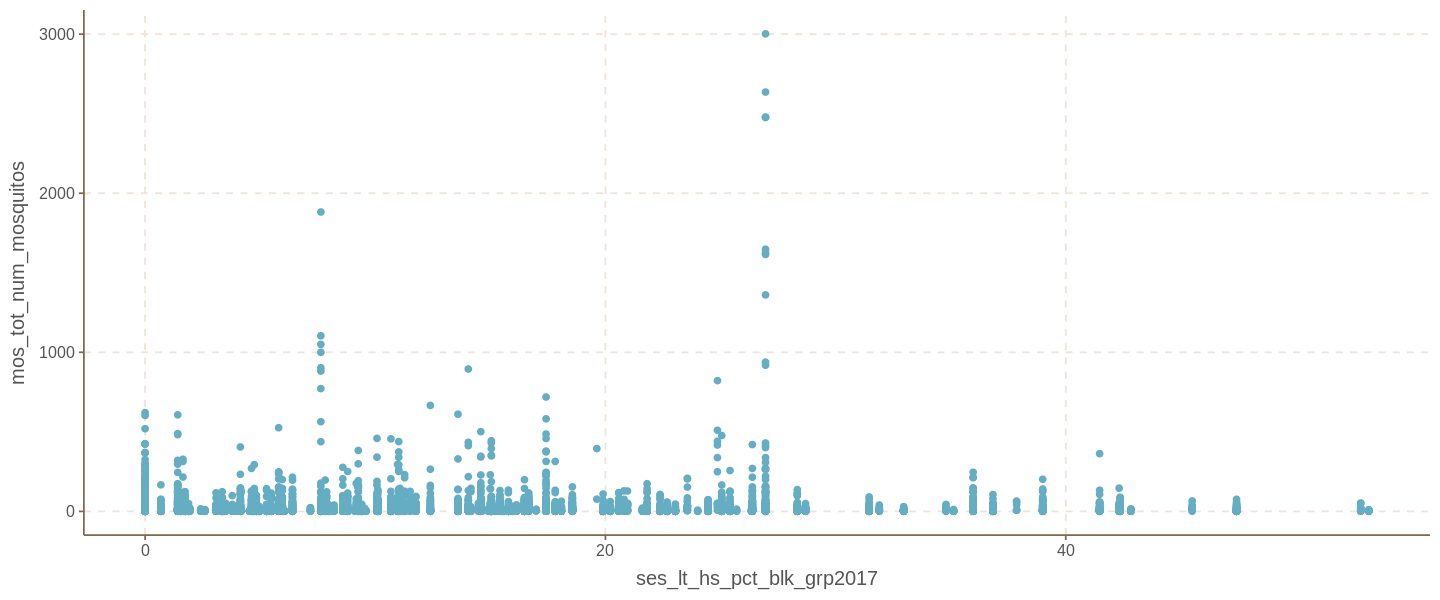

In [32]:
options(repr.plot.width=12, repr.plot.height=5)
df_train %>%
    ggplot()+
    geom_boxplot(aes(y=ses_lt_hs_pct_blk_grp2017,fill=mos_any_wnv_present))
df_train %>%
    ggplot()+
    geom_point(aes(x=ses_lt_hs_pct_blk_grp2017,y=mos_tot_num_mosquitos))

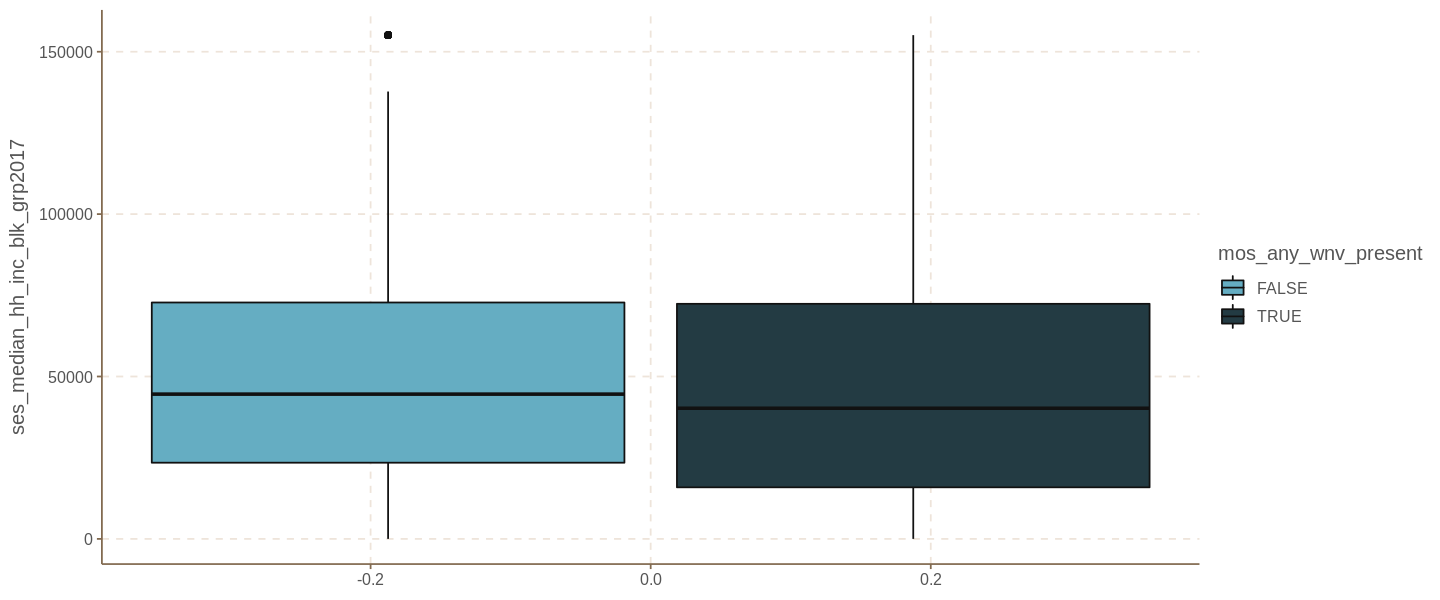

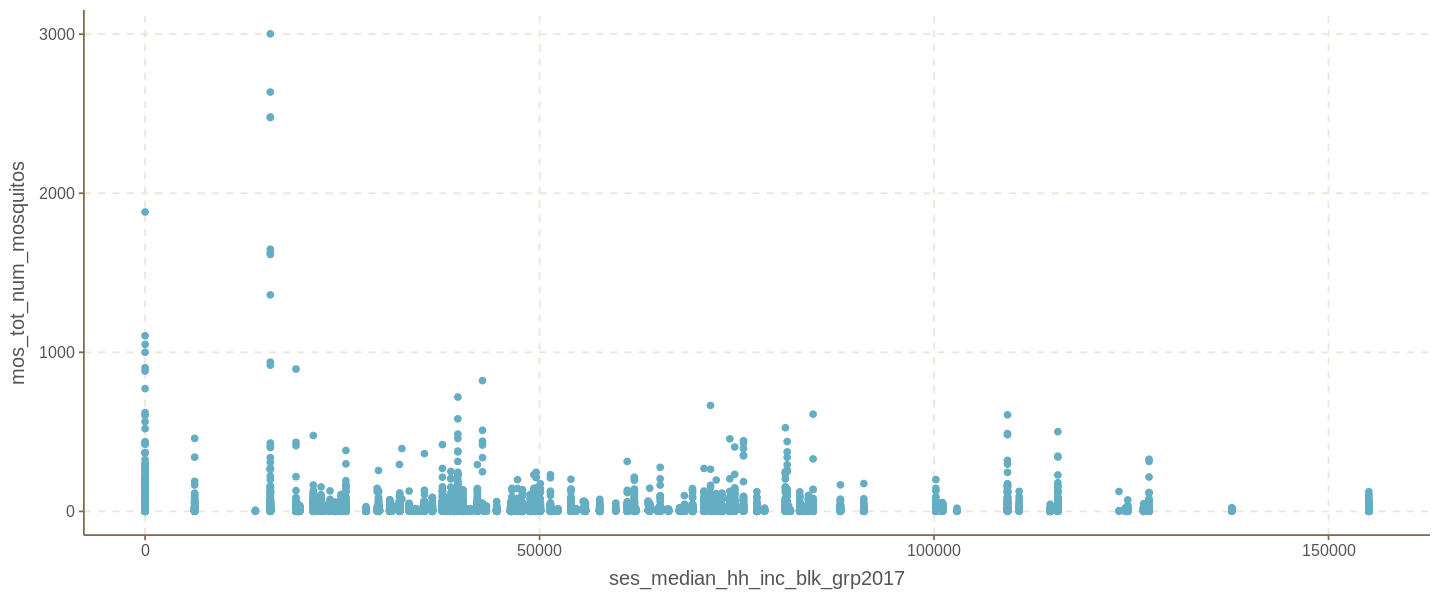

In [33]:
df_train %>%
    ggplot()+
    geom_boxplot(aes(y=ses_median_hh_inc_blk_grp2017,fill=mos_any_wnv_present))
df_train %>%
    ggplot()+
    geom_point(aes(x=ses_median_hh_inc_blk_grp2017,y=mos_tot_num_mosquitos))

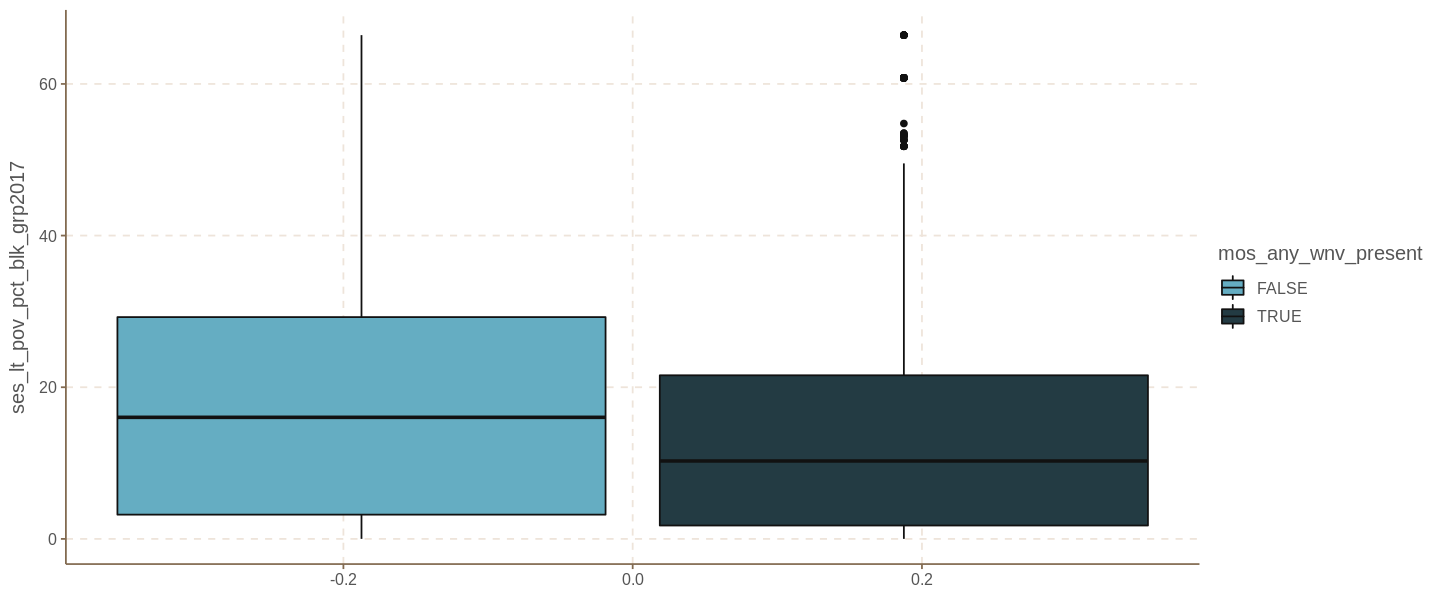

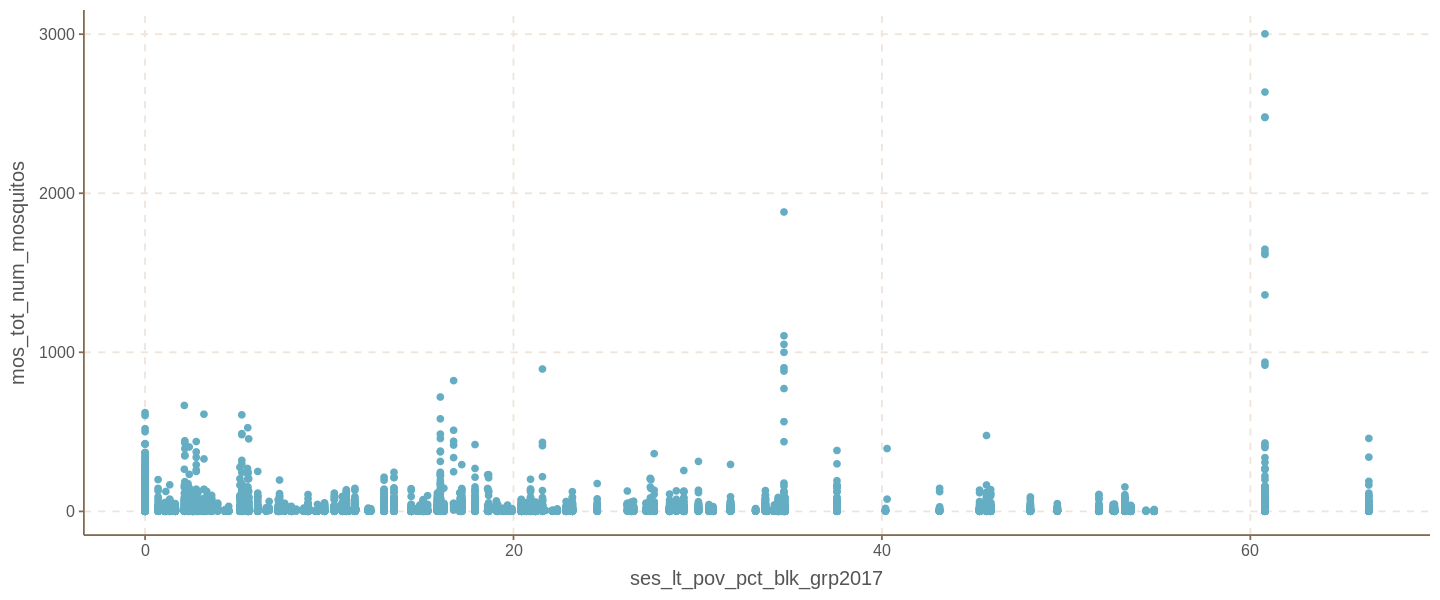

In [34]:
df_train %>%
    ggplot()+
    geom_boxplot(aes(y=ses_lt_pov_pct_blk_grp2017,fill=mos_any_wnv_present))
df_train %>%
    ggplot()+
    geom_point(aes(x=ses_lt_pov_pct_blk_grp2017,y=mos_tot_num_mosquitos))

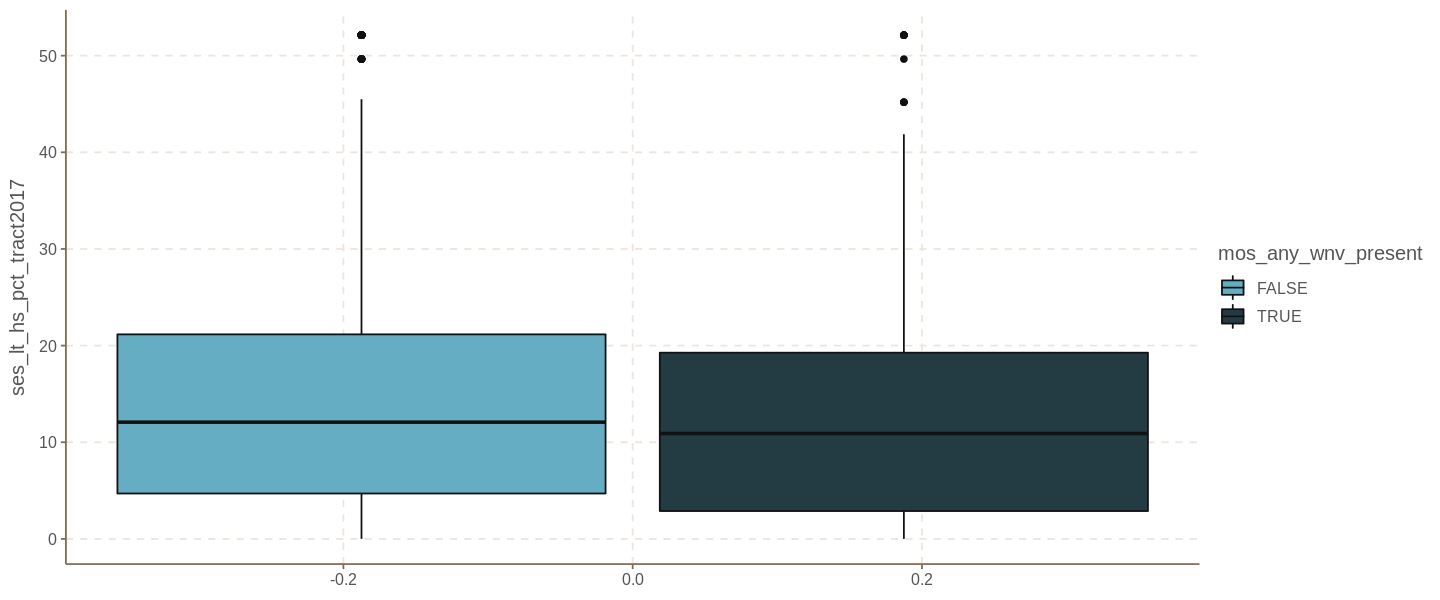

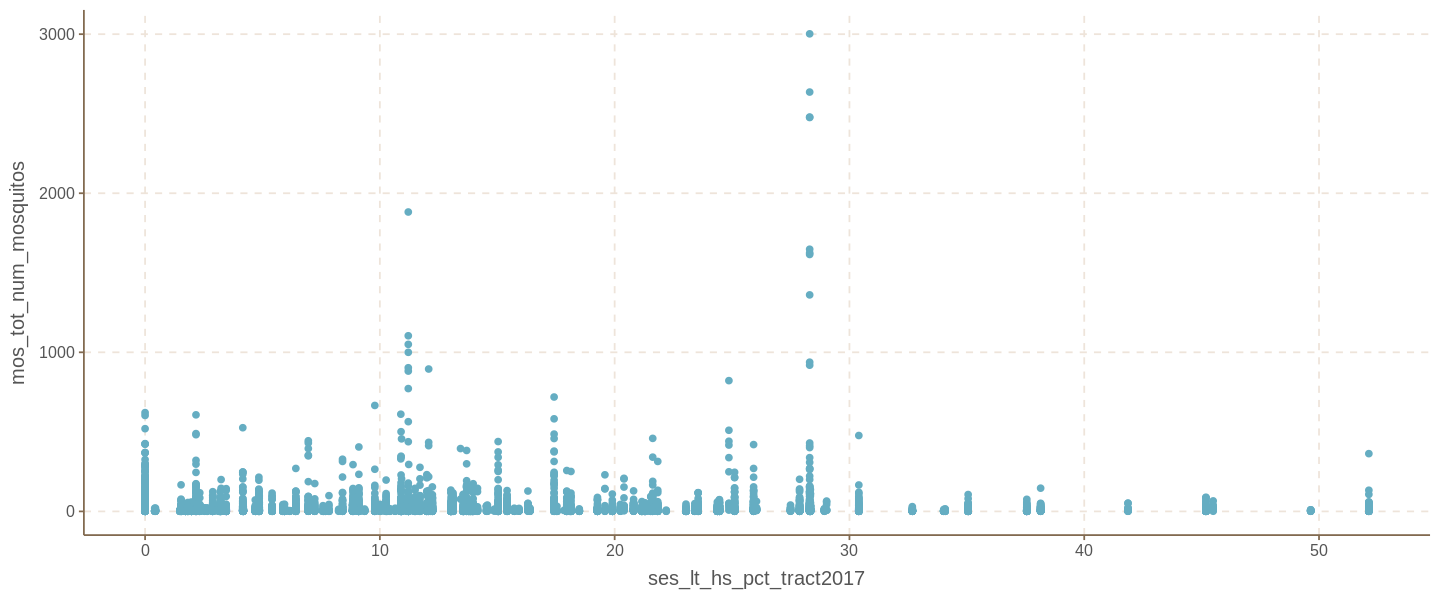

In [35]:
df_train %>%
    ggplot()+
    geom_boxplot(aes(y=ses_lt_hs_pct_tract2017,fill=mos_any_wnv_present))
df_train %>%
    ggplot()+
    geom_point(aes(x=ses_lt_hs_pct_tract2017,y=mos_tot_num_mosquitos))

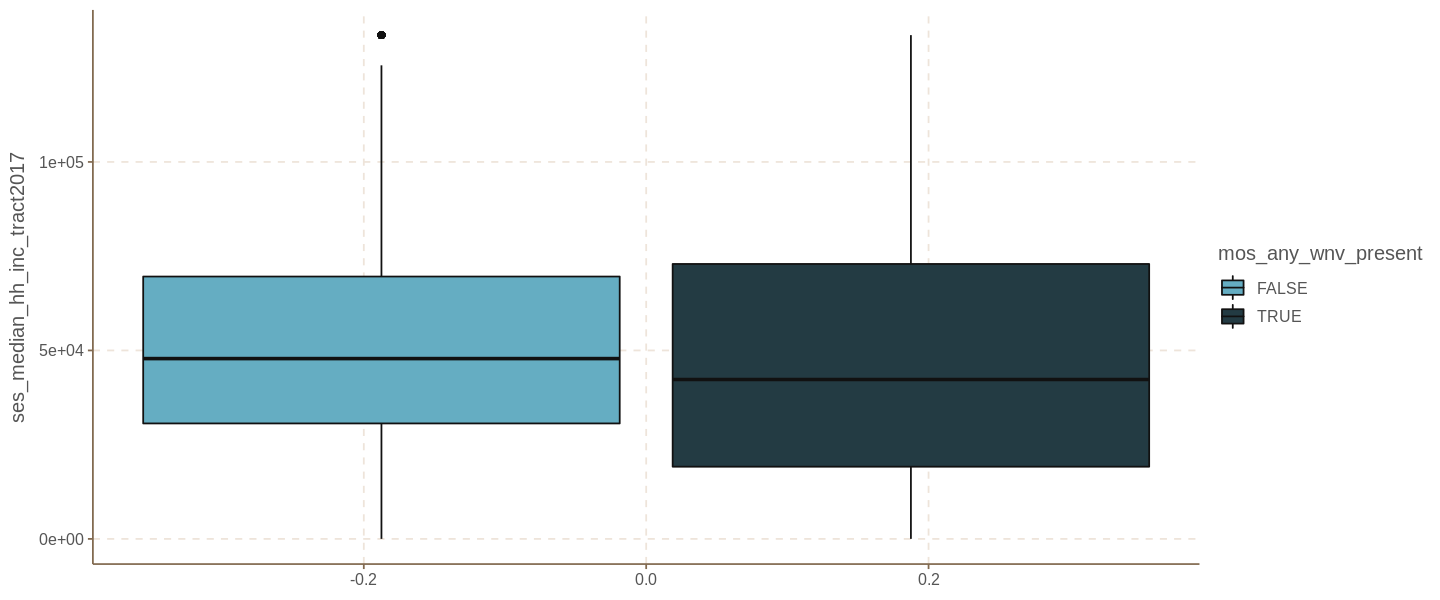

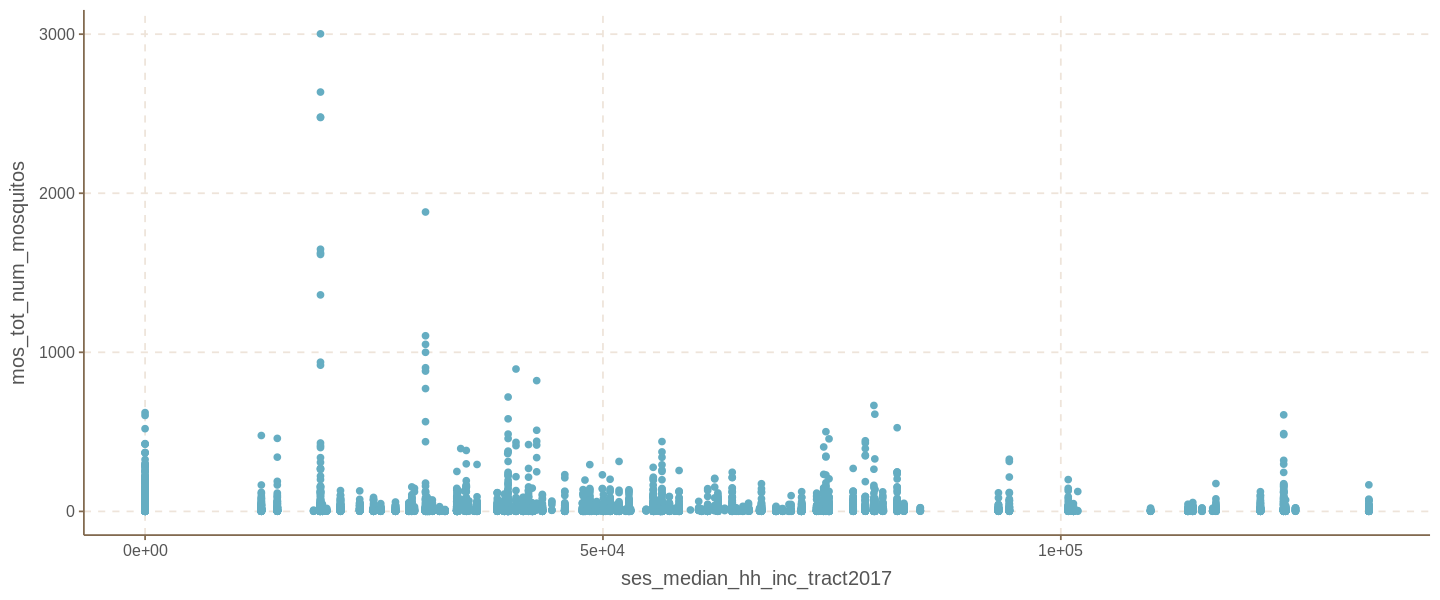

In [36]:
df_train %>%
    ggplot()+
    geom_boxplot(aes(y=ses_median_hh_inc_tract2017,fill=mos_any_wnv_present))
df_train %>%
    ggplot()+
    geom_point(aes(x=ses_median_hh_inc_tract2017,y=mos_tot_num_mosquitos))

This one seems to have the most promise -->

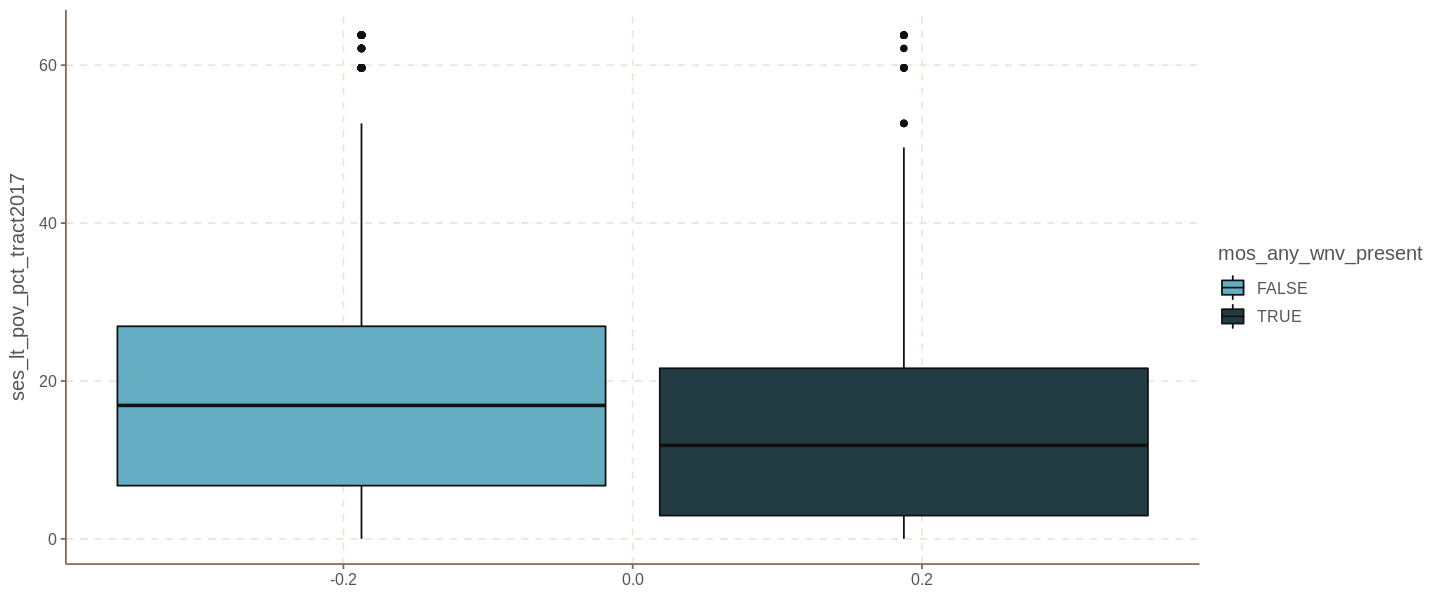

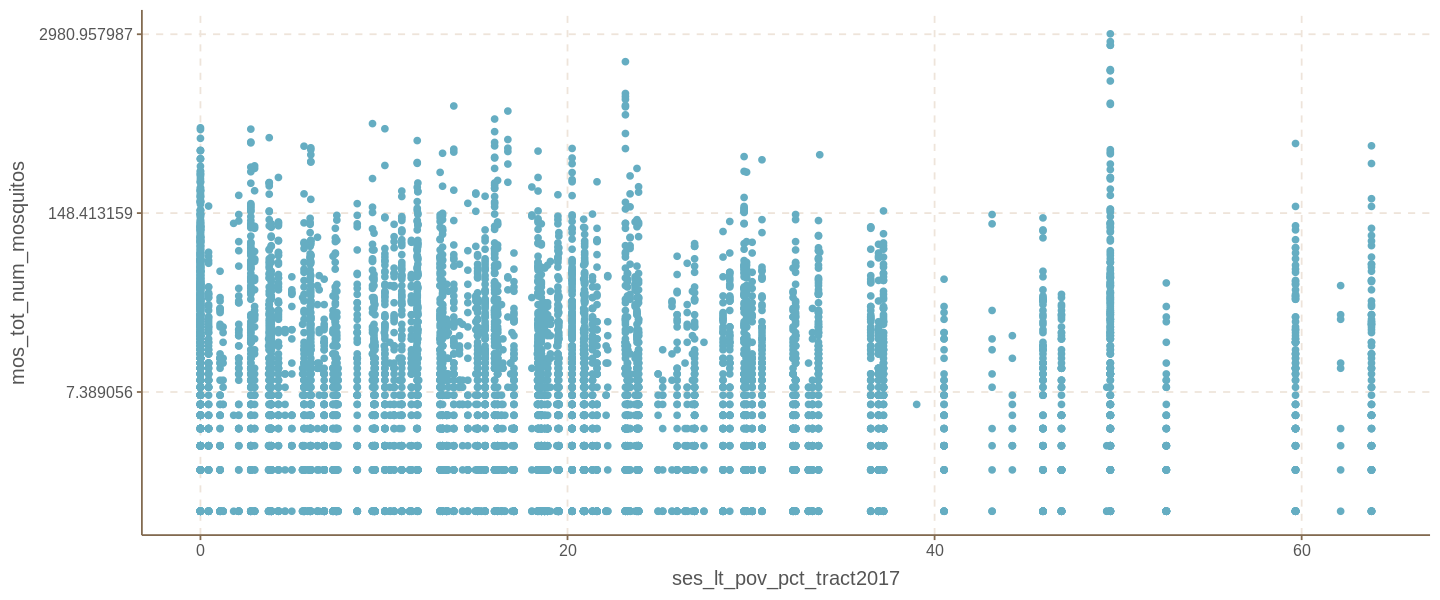

In [37]:
df_train %>%
    ggplot()+
    geom_boxplot(aes(y=ses_lt_pov_pct_tract2017,fill=mos_any_wnv_present))
df_train %>%
    ggplot()+
    geom_point(aes(x=ses_lt_pov_pct_tract2017,y=mos_tot_num_mosquitos))+
    scale_y_continuous(trans = "log")

# Do the neighbourhood variables offer any value?

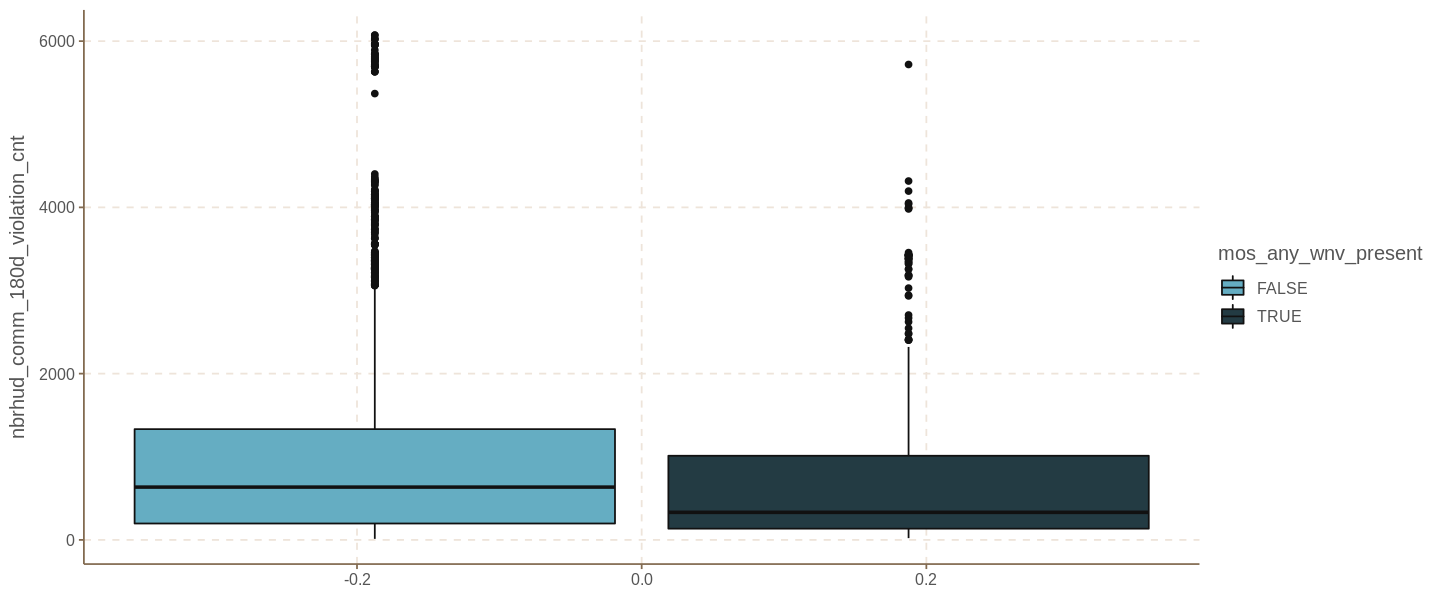

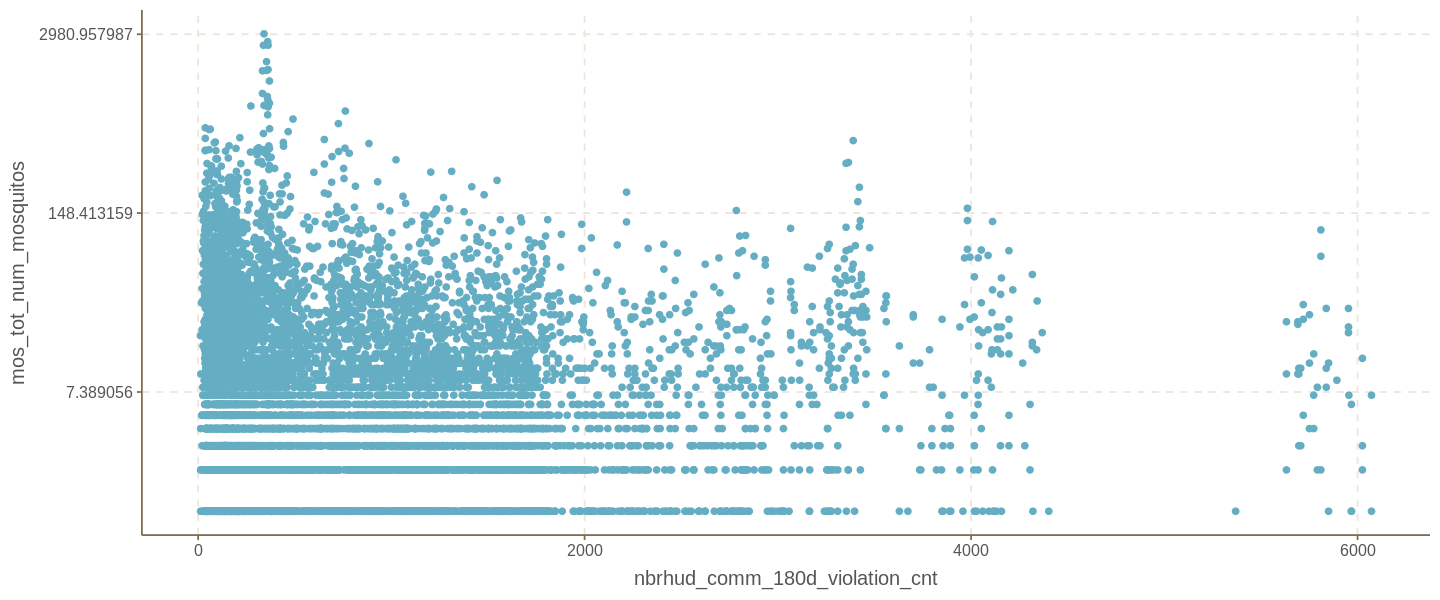

In [38]:
df_train %>%
    ggplot()+
    geom_boxplot(aes(y=nbrhud_comm_180d_violation_cnt,fill=mos_any_wnv_present))
df_train %>%
    ggplot()+
    geom_point(aes(x=nbrhud_comm_180d_violation_cnt,y=mos_tot_num_mosquitos))+
    scale_y_continuous(trans = "log")

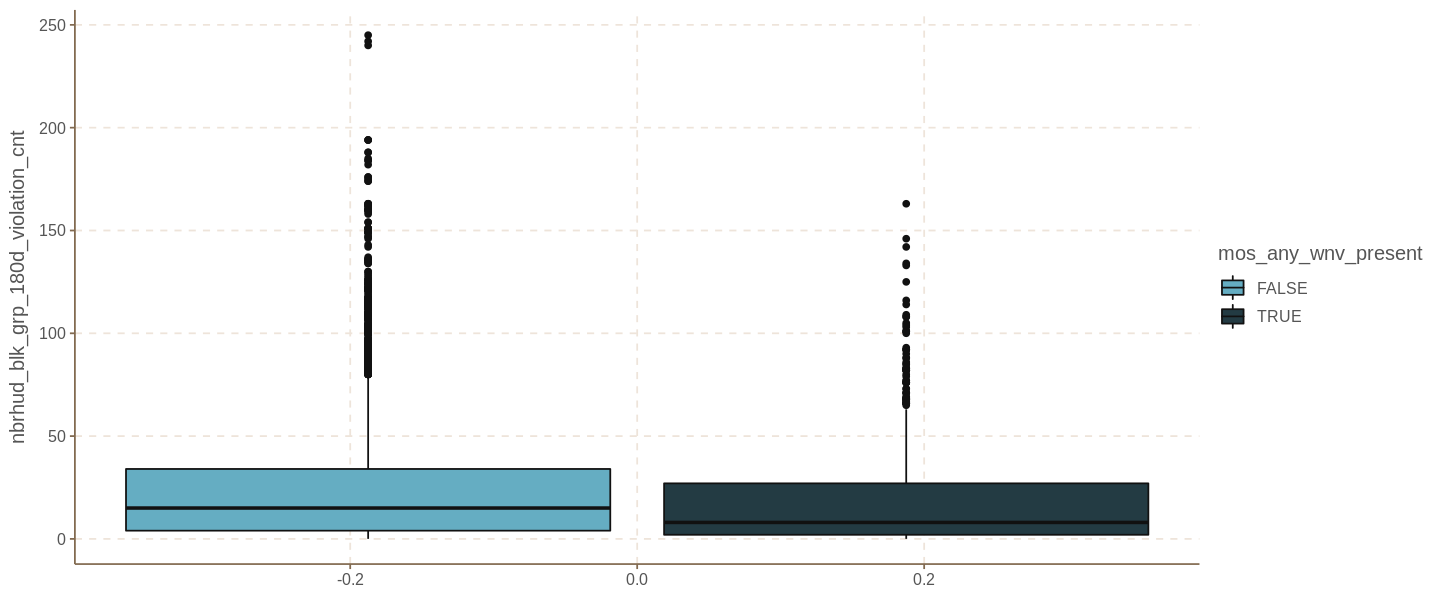

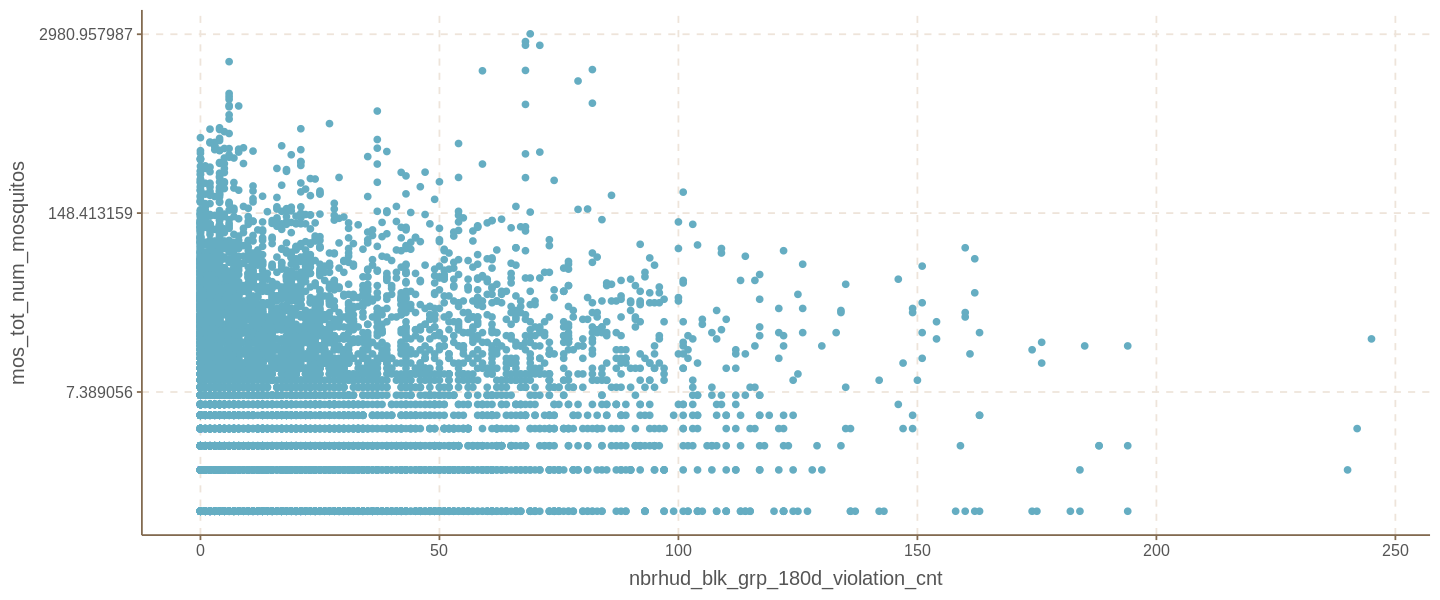

In [39]:
df_train %>%
    ggplot()+
    geom_boxplot(aes(y=nbrhud_blk_grp_180d_violation_cnt,fill=mos_any_wnv_present))
df_train %>%
    ggplot()+
    geom_point(aes(x=nbrhud_blk_grp_180d_violation_cnt,y=mos_tot_num_mosquitos))+
    scale_y_continuous(trans = "log")

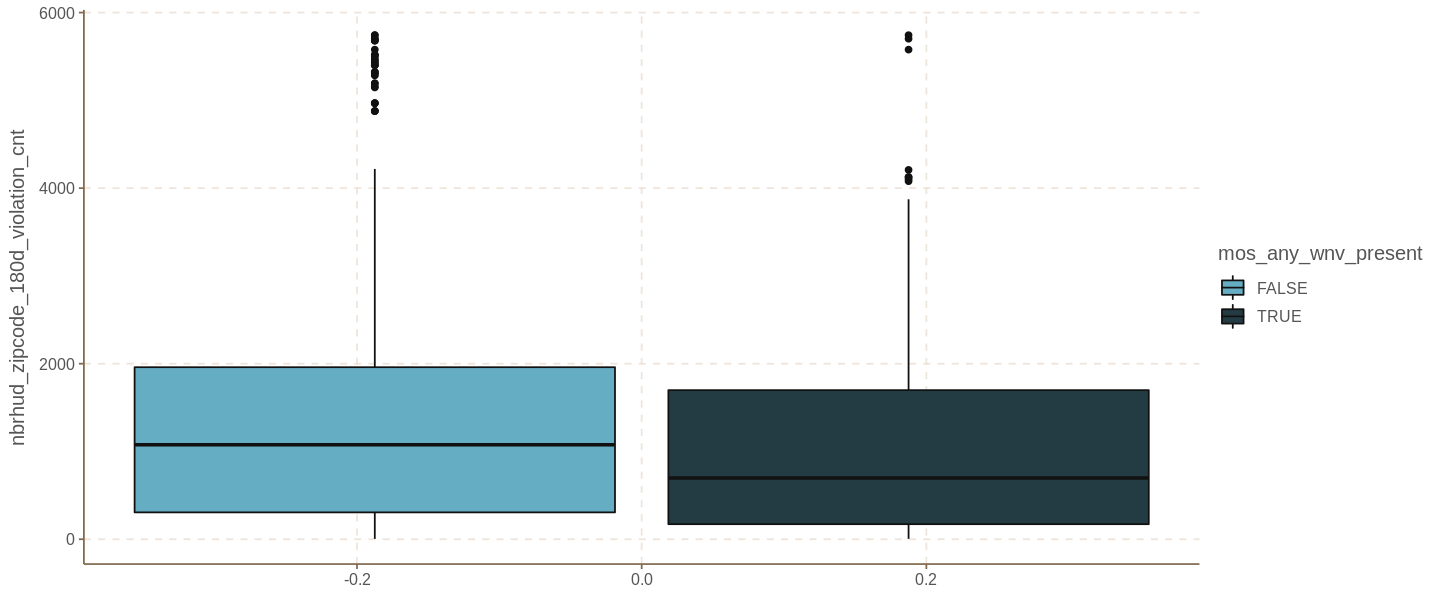

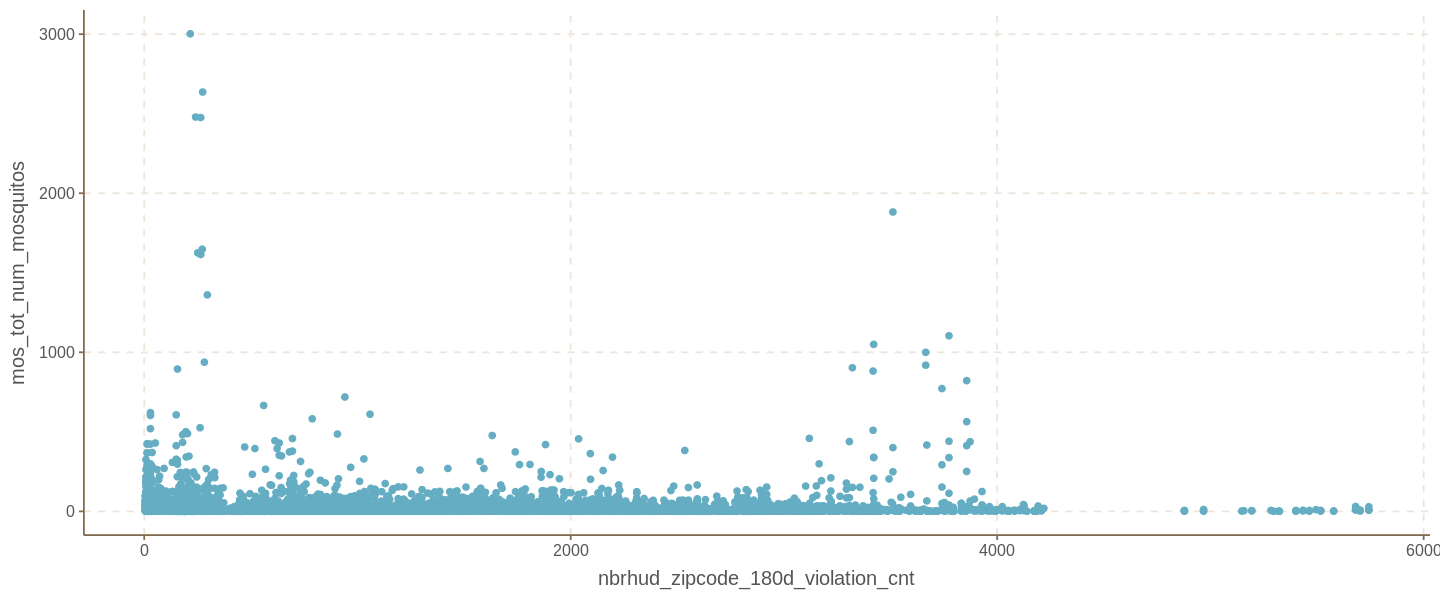

In [40]:
df_train %>%
    ggplot()+
    geom_boxplot(aes(y=nbrhud_zipcode_180d_violation_cnt,fill=mos_any_wnv_present))
df_train %>%
    ggplot()+
    geom_point(aes(x=nbrhud_zipcode_180d_violation_cnt,y=mos_tot_num_mosquitos))

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 6564 rows containing non-finite values (stat_boxplot).”

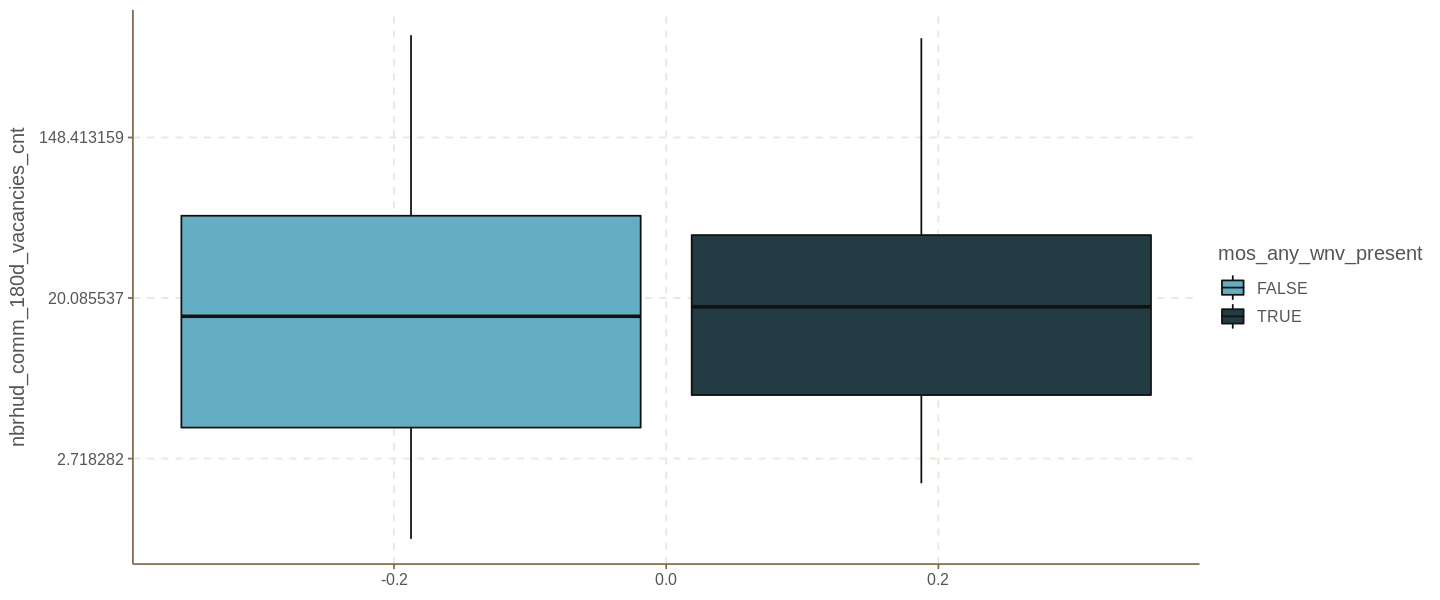

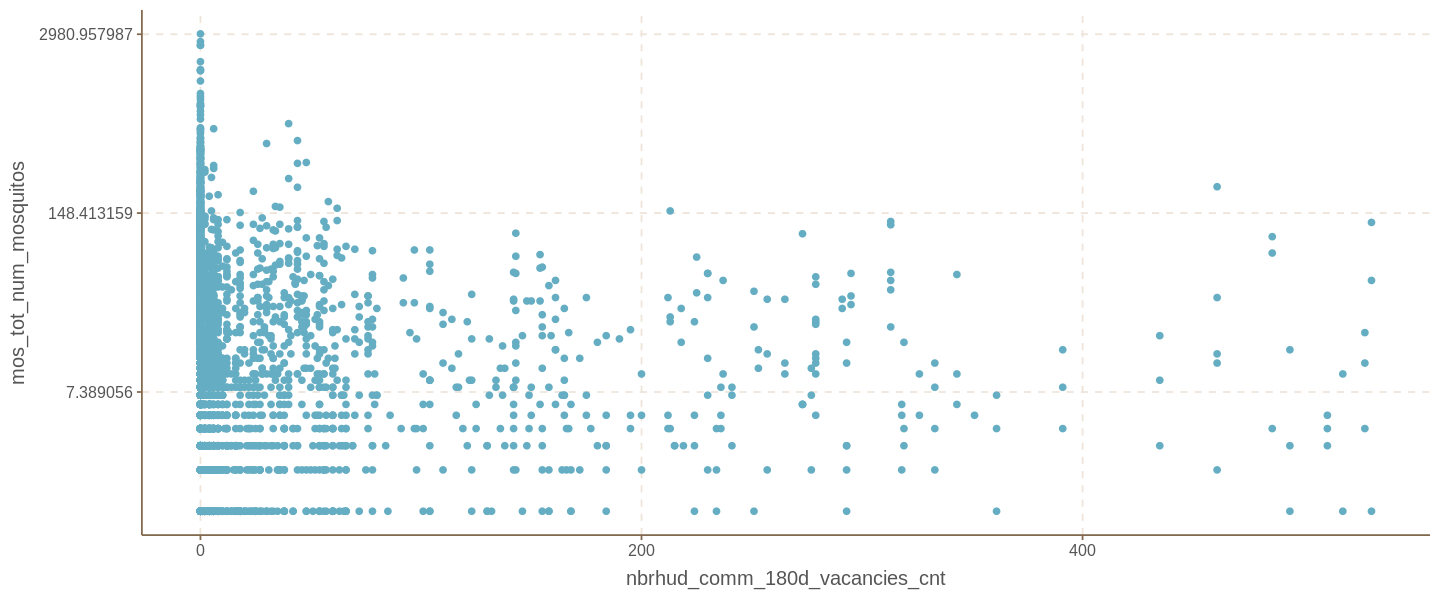

In [41]:
df_train %>%
    ggplot()+
    geom_boxplot(aes(y=nbrhud_comm_180d_vacancies_cnt,fill=mos_any_wnv_present))+
    scale_y_continuous(trans = "log")
df_train %>%
    ggplot()+
    geom_point(aes(x=nbrhud_comm_180d_vacancies_cnt,y=mos_tot_num_mosquitos))+
    scale_y_continuous(trans = "log")

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 7960 rows containing non-finite values (stat_boxplot).”

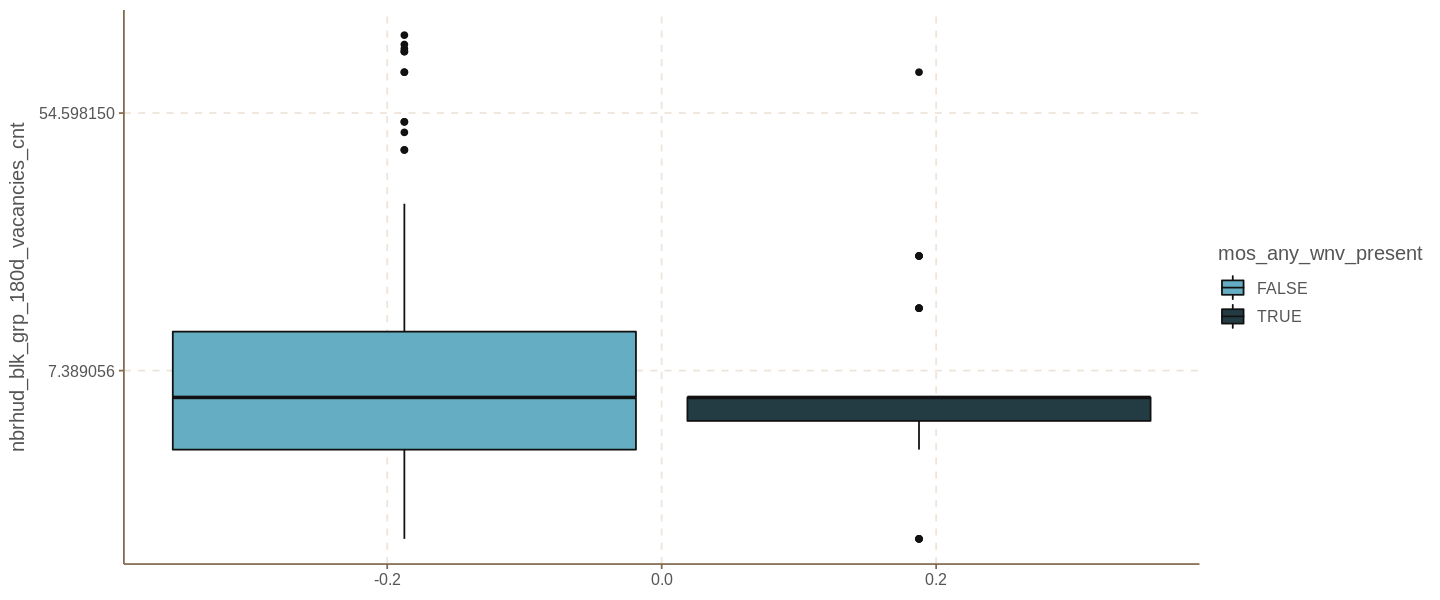

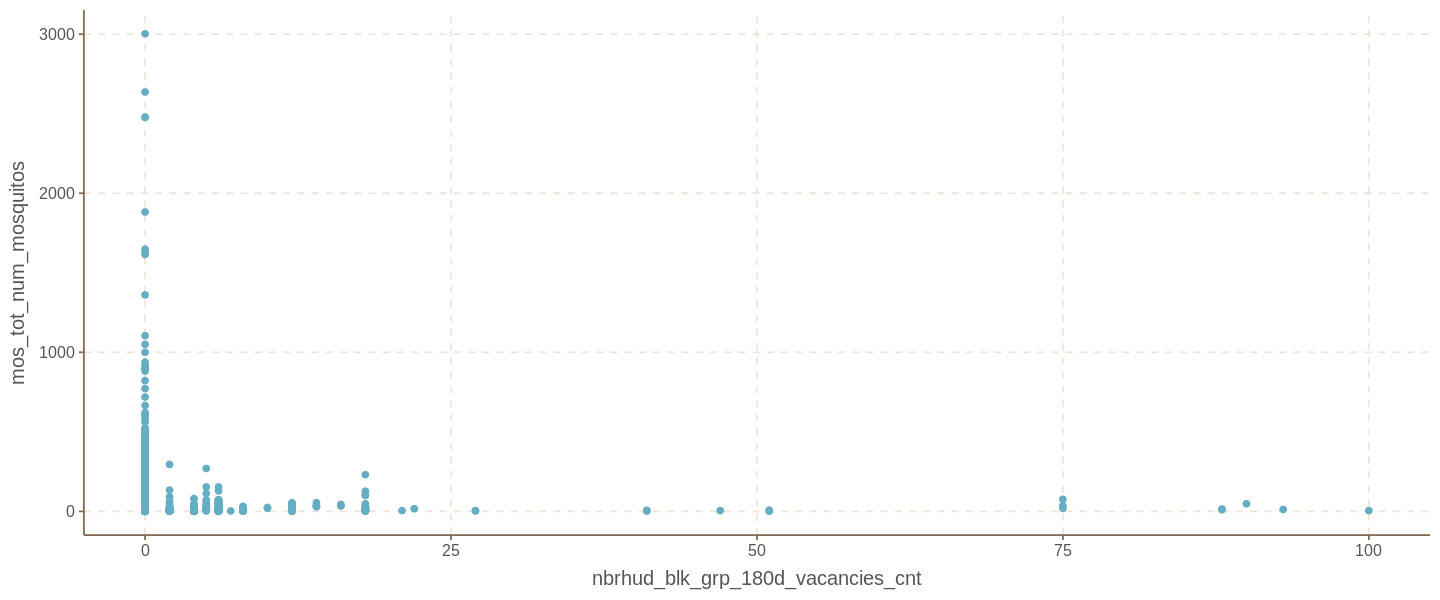

In [42]:
df_train %>%
    ggplot()+
    geom_boxplot(aes(y=nbrhud_blk_grp_180d_vacancies_cnt,fill=mos_any_wnv_present))+
    scale_y_continuous(trans = "log")
df_train %>%
    ggplot()+
    geom_point(aes(x=nbrhud_blk_grp_180d_vacancies_cnt,y=mos_tot_num_mosquitos))

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 6271 rows containing non-finite values (stat_boxplot).”

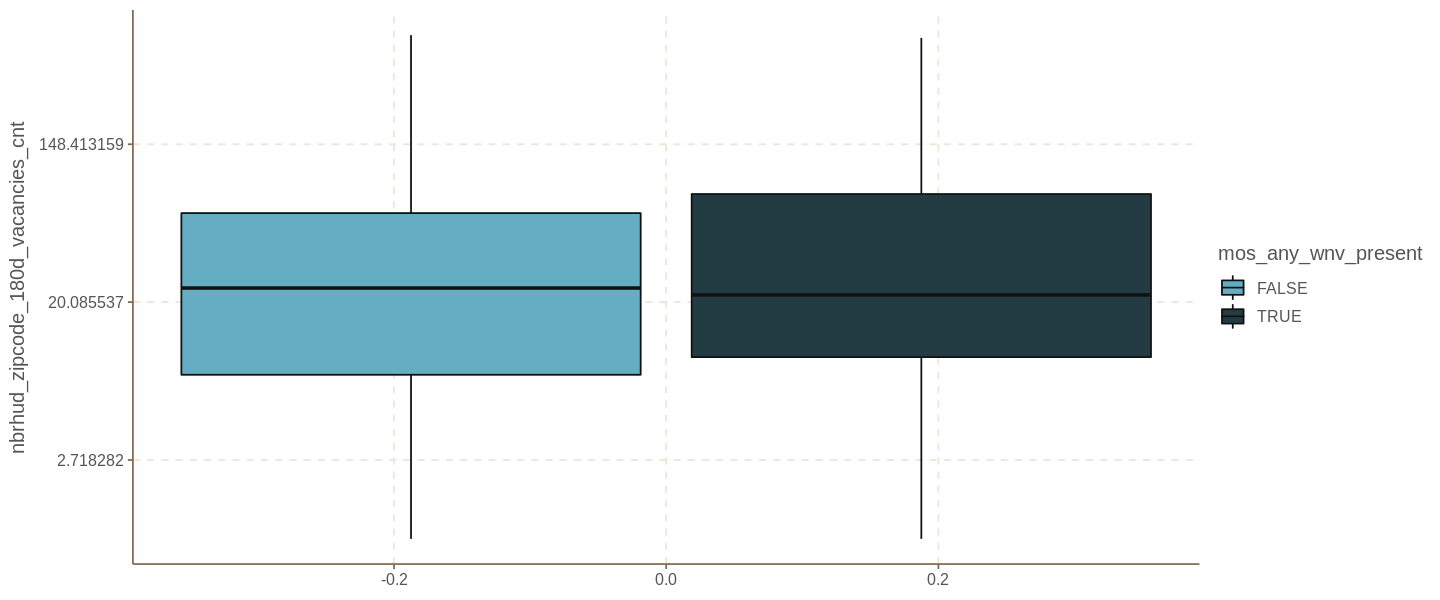

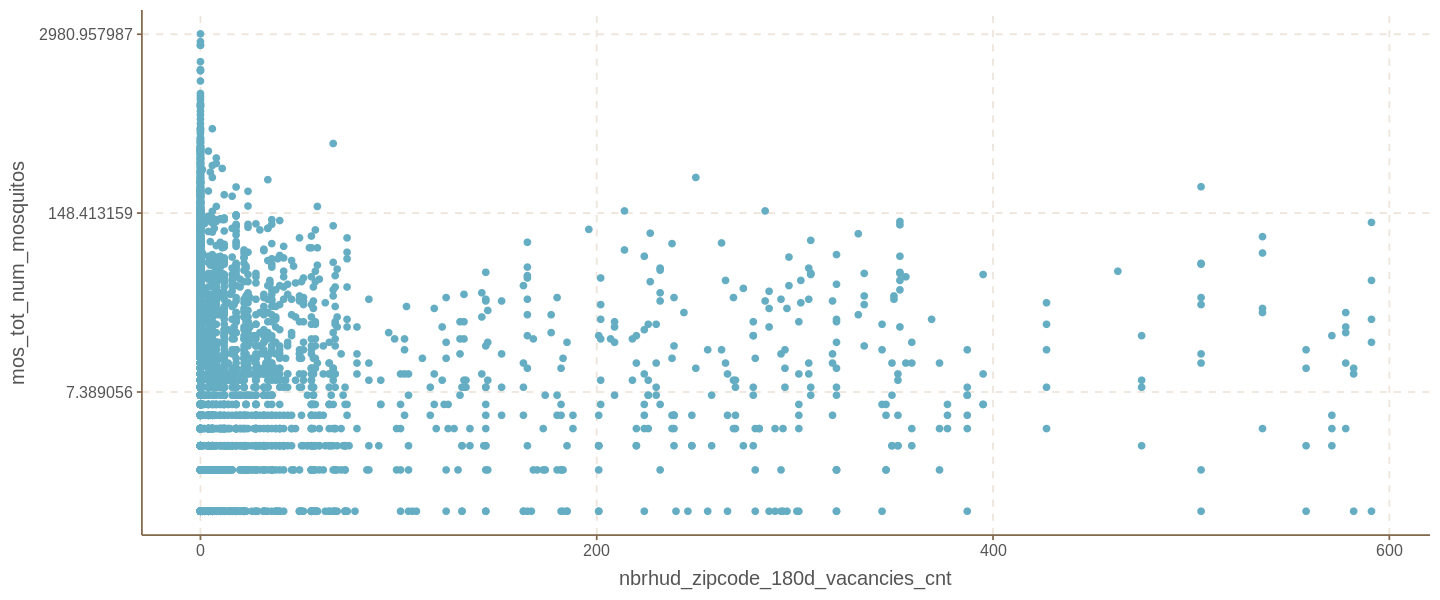

In [43]:
df_train %>%
    ggplot()+
    geom_boxplot(aes(y=nbrhud_zipcode_180d_vacancies_cnt,fill=mos_any_wnv_present))+
    scale_y_continuous(trans = "log")
df_train %>%
    ggplot()+
    geom_point(aes(x=nbrhud_zipcode_180d_vacancies_cnt,y=mos_tot_num_mosquitos))+
    scale_y_continuous(trans = "log")

# Now looking at the weather

## OHare Weather

In [190]:
df_sub = df_train %>% dplyr::select("t_date",starts_with("wea_ohare_"),"mos_any_wnv_present","mos_tot_num_mosquitos")

In [191]:
head(df_sub)

t_date     wea_ohare_prcp wea_ohare_tavg2 wea_ohare_tmax wea_ohare_tmin
1 2007-05-29 0              74              88             60            
2 2007-05-29 0              74              88             60            
3 2007-05-29 0              74              88             60            
4 2007-05-29 0              74              88             60            
5 2007-05-29 0              74              88             60            
6 2007-05-29 0              74              88             60            
  wea_ohare_tavg2_ma7 wea_ohare_tavg2_ma60 wea_ohare_prcp_sum7
1 67.35714            54.375               1.07               
2 67.35714            54.375               1.07               
3 67.35714            54.375               1.07               
4 67.35714            54.375               1.07               
5 67.35714            54.375               1.07               
6 67.35714            54.375               1.07               
  wea_ohare_prcp_sum60 wea_ohare_prcp_sum60_lag7 ⋯ wea_ohare_tavg2_ma60_lag28
1 5.79                 4.96                      ⋯ 44.69167                  
2 5.79                 4.96                      ⋯ 44.69167                  
3 5.79                 4.96                      ⋯ 44.69167                  
4 5.79                 4.96                      ⋯ 44.69167                  
5 5.79                 4.96                      ⋯ 44.69167                  
6 5.79                 4.96                      ⋯ 44.69167                  
  wea_ohare_tavg2_ma60_lag35 wea_ohare_tavg2_ma60_lag42
1 42.1                       38.61667                  
2 42.1                       38.61667                  
3 42.1                       38.61667                  
4 42.1                       38.61667                  
5 42.1                       38.61667                  
6 42.1                       38.61667                  
  wea_ohare_tavg2_ma60_lag49 wea_ohare_tavg2_ma60_lag56
1 35.55                      31.775                    
2 35.55                      31.775                    
3 35.55                      31.775                    
4 35.55                      31.775                    
5 35.55                      31.775                    
6 35.55                      31.775                    
  wea_ohare_tavg2_ma60_lag63 wea_ohare_tavg2_ma60_lag90
1 27.80833                   23.83333                  
2 27.80833                   23.83333                  
3 27.80833                   23.83333                  
4 27.80833                   23.83333                  
5 27.80833                   23.83333                  
6 27.80833                   23.83333                  
  wea_ohare_tavg2_ma60_lag120 mos_any_wnv_present mos_tot_num_mosquitos
1 31.73333                    FALSE               2                    
2 31.73333                    FALSE               2                    
3 31.73333                    FALSE               1                    
4 31.73333                    FALSE               5                    
5 31.73333                    FALSE               5                    
6 31.73333                    FALSE               2

The various lag variables created so far are HIGHLY correlated. We'll need to be selective during modeling.

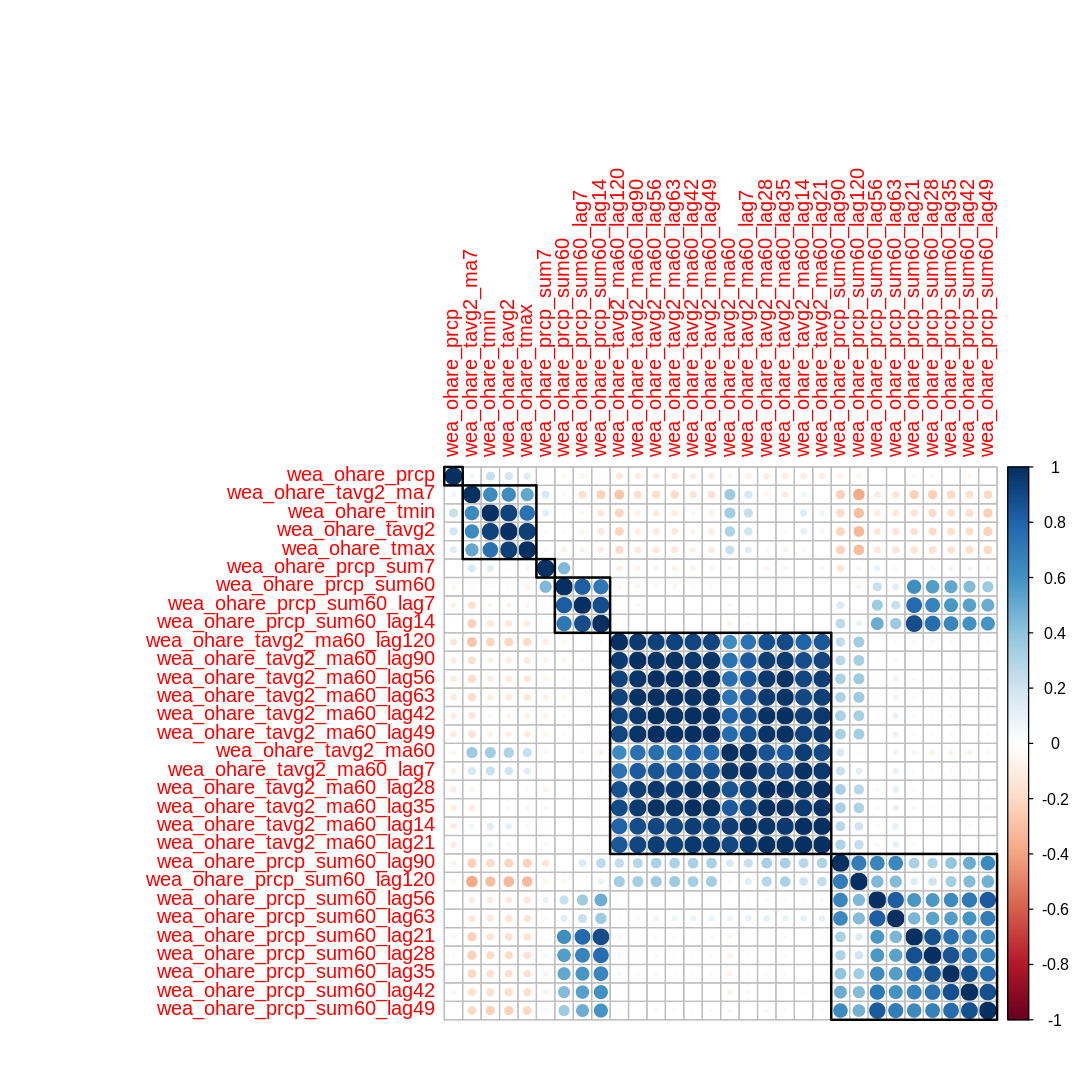

In [192]:
options(repr.plot.width=9, repr.plot.height=9)
cor(df_sub %>% select(starts_with("wea"))) %>% corrplot::corrplot(order = "hclust",addrect = 6)

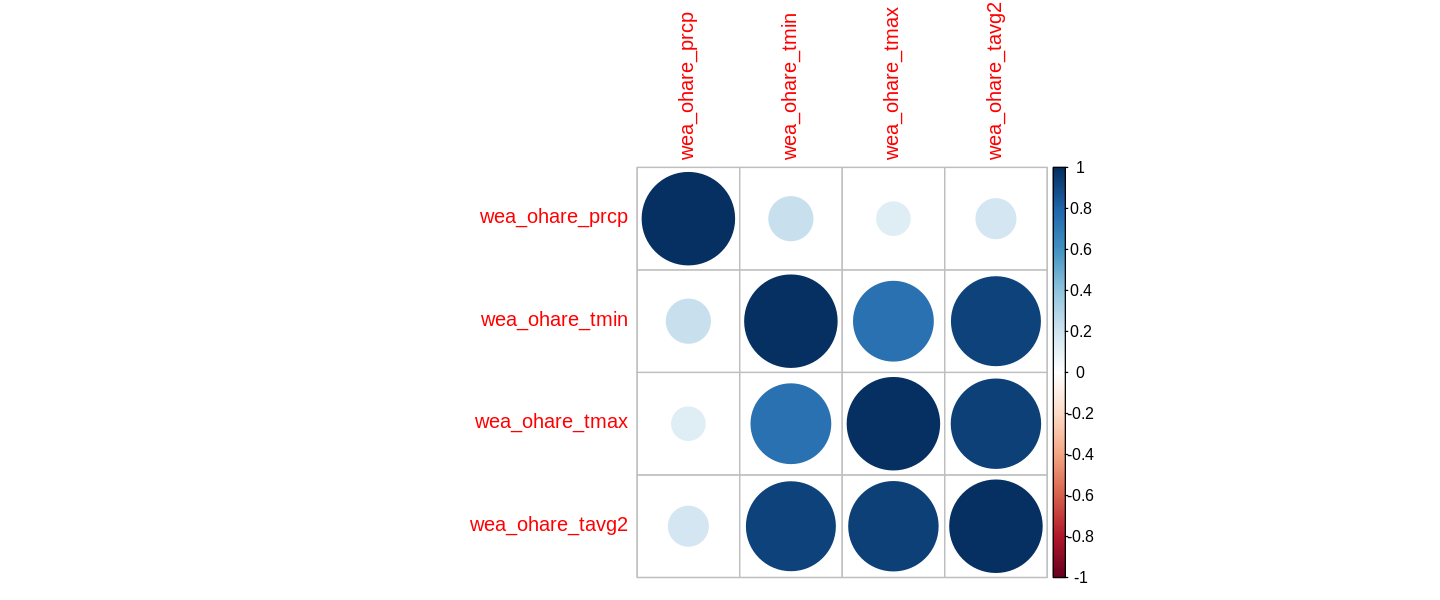

In [193]:
options(repr.plot.width=12, repr.plot.height=5)
df_sub %>% 
    select(ends_with("prcp"),ends_with("tmin"),ends_with("tmax"),ends_with("tavg2")) %>% 
    cor() %>% 
    corrplot::corrplot(order = "hclust")

## Time series plot of the O Hare weather data, by year

Temperatures

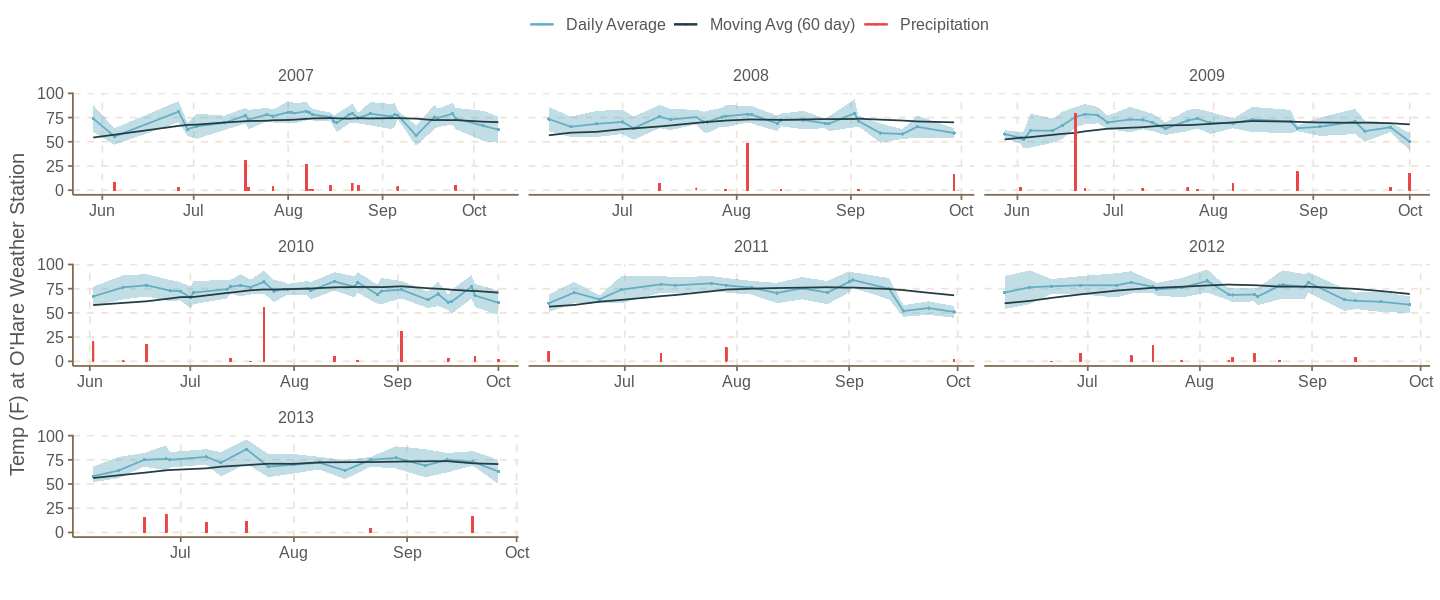

In [242]:
df_sub %>%
    ggplot(aes(x=t_date))+
    geom_ribbon(aes(ymin=wea_ohare_tmin,ymax=wea_ohare_tmax),alpha=0.4)+
    geom_point(aes(y=wea_ohare_tavg2,color="Daily Average"),size=.001)+
    geom_line(aes(y=wea_ohare_tavg2,color="Daily Average"))+
    geom_line(aes(y=wea_ohare_tavg2_ma60,color="Moving Avg (60 day)"))+
    geom_segment(aes(xend=t_date,y=0,yend=wea_ohare_prcp*20,color="Precipitation"))+
    facet_wrap(~lubridate::year(t_date), scales = "free_x")+
    theme(legend.position = "top")+
    labs(x="",y="Temp (F) at O'Hare Weather Station",color="")

Precipitation

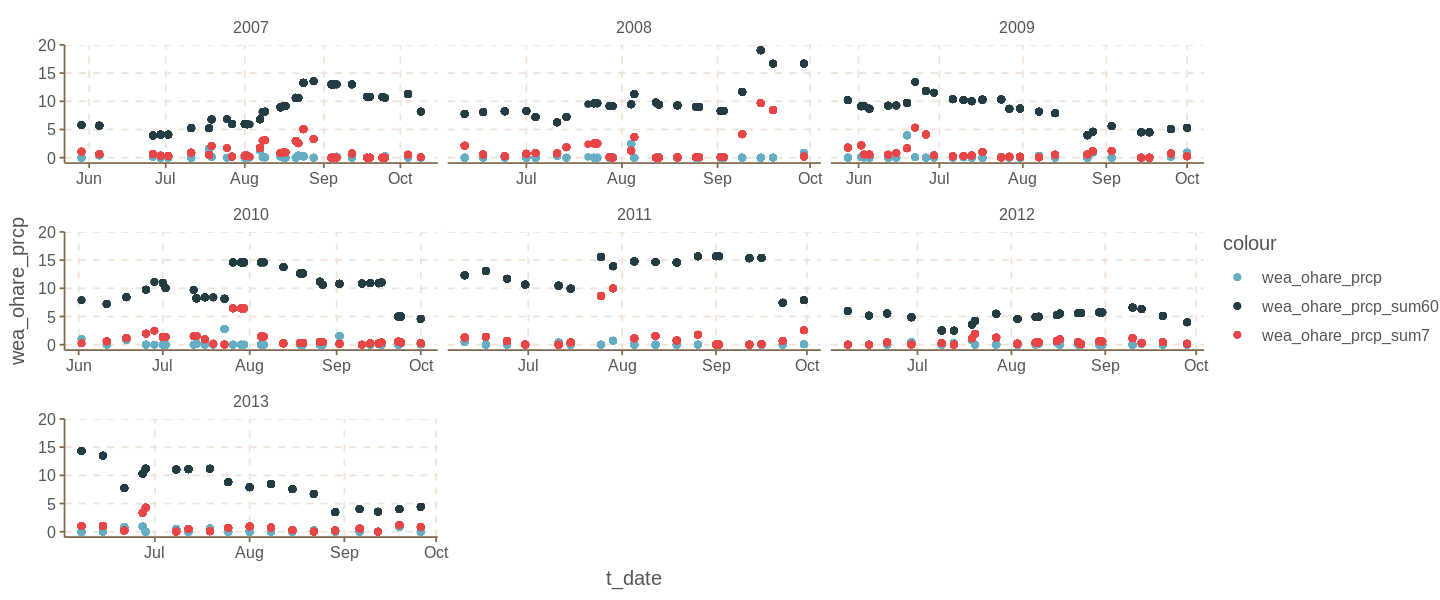

In [71]:
df_sub %>%
    ggplot(aes(x=t_date))+
    geom_point(aes(y=wea_ohare_prcp,color="wea_ohare_prcp"))+
    geom_point(aes(y=wea_ohare_prcp_sum7,color="wea_ohare_prcp_sum7"))+
    geom_point(aes(y=wea_ohare_prcp_sum60,color="wea_ohare_prcp_sum60"))+
    facet_wrap(~lubridate::year(t_date), scales = "free_x")

# zero variance and near zero variance analysis

In [49]:
library("caret")

In [55]:
nzv = nearZeroVar(df_train, saveMetrics = T, allowParallel = T)

In [60]:
nzv

freqRatio   percentUnique zeroVar nzv  
t_date                           1.009434 2.09194843    FALSE   FALSE
t_yr                             1.119175 0.08513744    FALSE   FALSE
t_mo                             1.122031 0.07297495    FALSE   FALSE
t_day                            1.158898 0.37703722    FALSE   FALSE
t_qtr                            4.516838 0.03648747    FALSE   FALSE
t_wk                             1.107362 0.24324982    FALSE   FALSE
t_day_of_yr                      1.260638 1.30138652    FALSE   FALSE
t_day_of_wk                      1.652472 0.06081245    FALSE   FALSE
t_day_of_wk_name                 1.652472 0.06081245    FALSE   FALSE
t_eval_day                       1.009434 2.09194843    FALSE   FALSE
t_eval_wk                        1.350318 1.37436147    FALSE   FALSE
trap_trap_name                   1.036364 2.17708587    FALSE   FALSE
loc_lat                          6.596491 1.90951107    FALSE   FALSE
loc_lng                          6.596491 1.89734858    FALSE   FALSE
loc_lat_lng_src                  6.501825 0.02432498    FALSE   FALSE
trap_satellite_ind              38.912621 0.02432498    FALSE    TRUE
loc_zipcode                      1.697517 0.57163707    FALSE   FALSE
loc_census_block_group_id        3.327434 1.72707370    FALSE   FALSE
loc_census_tract_id              3.327434 1.64193627    FALSE   FALSE
loc_community                    2.581040 0.76623693    FALSE   FALSE
zone_class                       1.079585 0.45001216    FALSE   FALSE
zone_type                        2.194156 0.08513744    FALSE   FALSE
ses_lt_hs_pct_blk_grp2017        4.269912 1.64193627    FALSE   FALSE
ses_median_hh_inc_blk_grp2017    4.853982 1.62977378    FALSE   FALSE
ses_lt_pov_pct_blk_grp2017       4.579646 1.65409876    FALSE   FALSE
ses_lt_hs_pct_tract2017          3.738938 1.62977378    FALSE   FALSE
ses_median_hh_inc_tract2017      3.738938 1.62977378    FALSE   FALSE
ses_lt_pov_pct_tract2017         3.738938 1.62977378    FALSE   FALSE
trap_trap_type                  23.687688 0.03648747    FALSE    TRUE
mos_erraticus_num_mosquitos   8221.000000 0.02432498    FALSE    TRUE
⋮                             ⋮           ⋮             ⋮       ⋮    
wea_midway_tavg2_ma60_lag28   1.069930    2.006811      FALSE   FALSE
wea_midway_tavg2_ma60_lag35   1.040268    2.018973      FALSE   FALSE
wea_midway_tavg2_ma60_lag42   1.000000    2.055461      FALSE   FALSE
wea_midway_tavg2_ma60_lag49   1.009434    2.067623      FALSE   FALSE
wea_midway_tavg2_ma60_lag56   1.068702    2.043298      FALSE   FALSE
wea_midway_tavg2_ma60_lag63   1.239669    2.031136      FALSE   FALSE
wea_midway_tavg2_ma60_lag90   1.308411    2.079786      FALSE   FALSE
wea_midway_tavg2_ma60_lag120  1.009434    2.079786      FALSE   FALSE
wea_ohare_prcp_sum60_lag7     1.319728    1.763561      FALSE   FALSE
wea_ohare_prcp_sum60_lag14    1.122449    1.739236      FALSE   FALSE
wea_ohare_prcp_sum60_lag21    1.139241    1.800049      FALSE   FALSE
wea_ohare_prcp_sum60_lag28    1.035211    1.727074      FALSE   FALSE
wea_ohare_prcp_sum60_lag35    1.260504    1.885186      FALSE   FALSE
wea_ohare_prcp_sum60_lag42    1.034722    1.800049      FALSE   FALSE
wea_ohare_prcp_sum60_lag49    1.146667    1.751399      FALSE   FALSE
wea_ohare_prcp_sum60_lag56    1.201550    1.739236      FALSE   FALSE
wea_ohare_prcp_sum60_lag63    1.324138    1.824374      FALSE   FALSE
wea_ohare_prcp_sum60_lag90    1.527950    1.641936      FALSE   FALSE
wea_ohare_prcp_sum60_lag120   1.324841    1.629774      FALSE   FALSE
wea_ohare_tavg2_ma60_lag7     1.033784    1.982486      FALSE   FALSE
wea_ohare_tavg2_ma60_lag14    1.009346    2.031136      FALSE   FALSE
wea_ohare_tavg2_ma60_lag21    1.420561    2.031136      FALSE   FALSE
wea_ohare_tavg2_ma60_lag28    1.355140    2.055461      FALSE   FALSE
wea_ohare_tavg2_ma60_lag35    1.130841    2.055461      FALSE   FALSE
wea_ohare_tavg2_ma60_lag42    1.015385    2.031136      FALSE   FALSE
wea_ohare_tavg2_ma60_lag49    1.112150  

### Vars with near zero var

In [58]:
names(df_train)[nzv$nzv]

[1] "trap_satellite_ind"                "trap_trap_type"                   
 [3] "mos_erraticus_num_mosquitos"       "mos_salinarius_num_mosquitos"     
 [5] "mos_tarsalis_num_mosquitos"        "mos_territans_num_mosquitos"      
 [7] "mos_unspecified_num_mosquitos"     "mos_erraticus_wnv_present"        
 [9] "mos_pipiens_wnv_present"           "mos_restuans_wnv_present"         
[11] "mos_salinarius_wnv_present"        "mos_tarsalis_wnv_present"         
[13] "mos_territans_wnv_present"         "mos_unspecified_wnv_present"      
[15] "nbrhud_comm_180d_vacancies_cnt"    "nbrhud_blk_grp_180d_vacancies_cnt"
[17] "nbrhud_zipcode_180d_vacancies_cnt" "wea_ohare_prcp"

In [76]:
nzv[nzv$nzv==T,]

freqRatio  percentUnique zeroVar nzv 
trap_satellite_ind                  38.91262 0.02432498    FALSE   TRUE
trap_trap_type                      23.68769 0.03648747    FALSE   TRUE
mos_erraticus_num_mosquitos       8221.00000 0.02432498    FALSE   TRUE
mos_salinarius_num_mosquitos        68.15254 0.12162491    FALSE   TRUE
mos_tarsalis_num_mosquitos         482.05882 0.09729993    FALSE   TRUE
mos_territans_num_mosquitos         25.04839 0.27973729    FALSE   TRUE
mos_unspecified_num_mosquitos      745.54545 0.07297495    FALSE   TRUE
mos_erraticus_wnv_present            0.00000 0.01216249     TRUE   TRUE
mos_pipiens_wnv_present             35.70536 0.02432498    FALSE   TRUE
mos_restuans_wnv_present            58.57971 0.02432498    FALSE   TRUE
mos_salinarius_wnv_present        2739.66667 0.02432498    FALSE   TRUE
mos_tarsalis_wnv_present             0.00000 0.01216249     TRUE   TRUE
mos_territans_wnv_present         8221.00000 0.02432498    FALSE   TRUE
mos_unspecified_wnv_present          0.00000 0.01216249     TRUE   TRUE
nbrhud_comm_180d_vacancies_cnt      34.91489 1.90951107    FALSE   TRUE
nbrhud_blk_grp_180d_vacancies_cnt  122.46154 0.27973729    FALSE   TRUE
nbrhud_zipcode_180d_vacancies_cnt   36.24855 2.23789832    FALSE   TRUE
wea_ohare_prcp                      28.46561 0.53514960    FALSE   TRUE

### Vars with zero var

In [59]:
names(df_train)[nzv$zeroVar]

[1] "mos_erraticus_wnv_present"   "mos_tarsalis_wnv_present"   
[3] "mos_unspecified_wnv_present"

# Time Series Analysis

In [79]:
ts_ = df_train %>% 
    select(ends_with("prcp"),ends_with("tmin"),ends_with("tmax"),ends_with("tavg2")) %>%
    xts::xts(order.by=df_train$t_date)

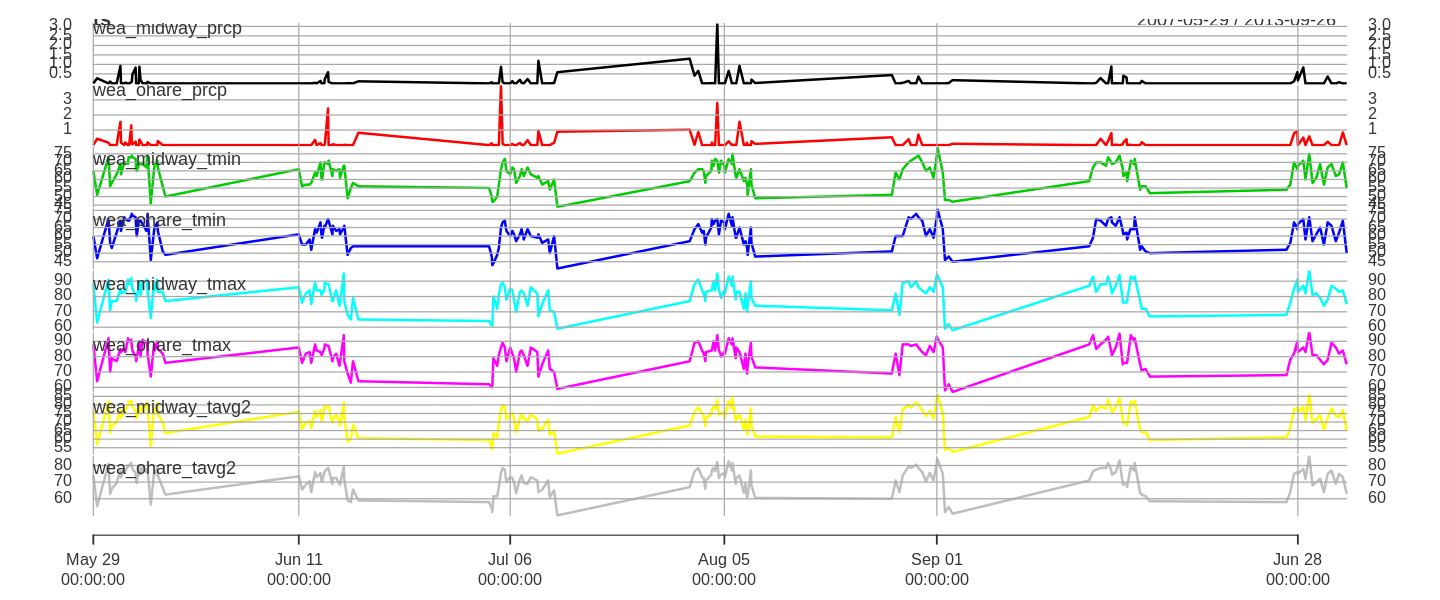

In [86]:
plot.xts(ts_, multi.panel = T,yaxis.same = F)

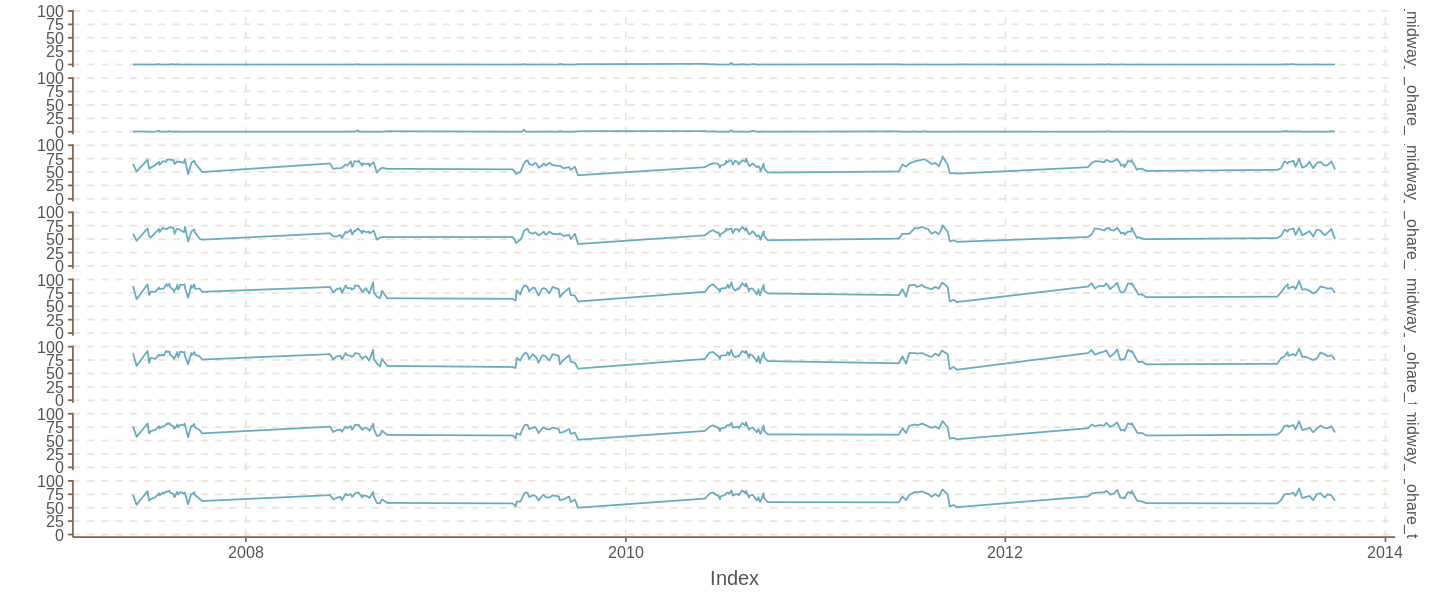

In [95]:
autoplot(ts_)

In [127]:
library(forecast)

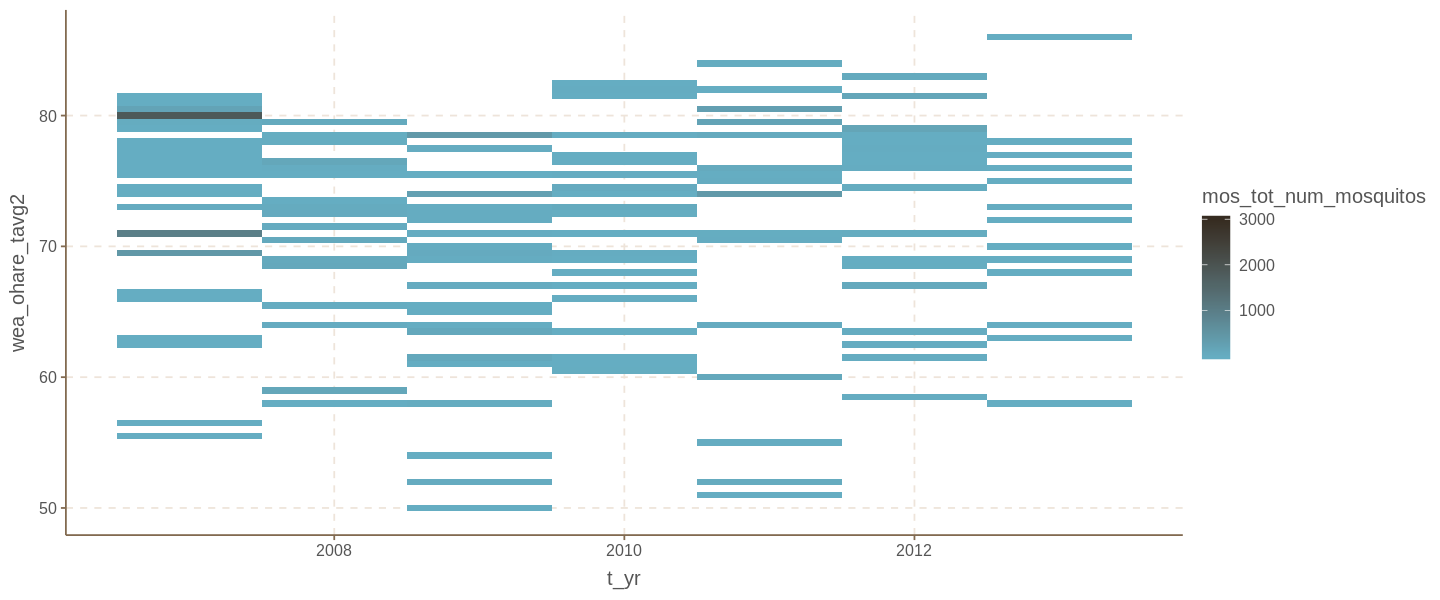

In [124]:
df_train %>% ggplot(aes(x=t_yr,y=wea_ohare_tavg2, fill=mos_tot_num_mosquitos))+
    geom_raster()

In [131]:
summary(ts_)

     Index            wea_midway_prcp  wea_ohare_prcp  wea_midway_tmin
 Min.   :2007-05-29   Min.   :0.0000   Min.   :0.000   Min.   :44.00  
 1st Qu.:2008-08-19   1st Qu.:0.0000   1st Qu.:0.000   1st Qu.:58.00  
 Median :2010-08-05   Median :0.0000   Median :0.000   Median :66.00  
 Mean   :2010-07-26   Mean   :0.1151   Mean   :0.189   Mean   :63.71  
 3rd Qu.:2012-07-19   3rd Qu.:0.0400   3rd Qu.:0.160   3rd Qu.:69.00  
 Max.   :2013-09-26   Max.   :3.1500   Max.   :3.970   Max.   :79.00  
 wea_ohare_tmin  wea_midway_tmax wea_ohare_tmax wea_midway_tavg2
 Min.   :41.00   Min.   :58.00   Min.   :57.0   Min.   :51.50   
 1st Qu.:57.00   1st Qu.:77.00   1st Qu.:76.0   1st Qu.:68.00   
 Median :63.00   Median :83.00   Median :83.0   Median :74.00   
 Mean   :61.71   Mean   :81.45   Mean   :81.3   Mean   :72.58   
 3rd Qu.:69.00   3rd Qu.:87.00   3rd Qu.:87.0   3rd Qu.:78.00   
 Max.   :76.00   Max.   :97.00   Max.   :96.0   Max.   :86.50   
 wea_ohare_tavg2
 Min.   :50.00  
 1st Qu.:66.50

In [132]:
library(suggrants)

ERROR: Error in library(suggrants): there is no package called ‘suggrants’


In [141]:
ggAcf(ts_$wea_midway_prcp, lag.max = 10, type = )

ERROR: Error in if (frequency > 1 && abs(frequency - round(frequency)) < ts.eps) frequency <- round(frequency): missing value where TRUE/FALSE needed


In [209]:
min_date = min(df_train$t_date)
max_date = max(df_train$t_date)
full_ts = tibble(t_date = seq(min_date,max_date,by = "day")) %>% left_join(df_train %>% distinct(t_date,.keep_all = T))

Joining, by = "t_date"


In [210]:
ts_ = full_ts %>% 
    select(ends_with("prcp"),ends_with("tmin"),ends_with("tmax"),ends_with("tavg2")) %>%
    xts::xts(order.by=full_ts$t_date)

In [211]:
head(ts_)

           wea_midway_prcp wea_ohare_prcp wea_midway_tmin wea_ohare_tmin
2007-05-29               0              0              65             60
2007-05-30              NA             NA              NA             NA
2007-05-31              NA             NA              NA             NA
2007-06-01              NA             NA              NA             NA
2007-06-02              NA             NA              NA             NA
2007-06-03              NA             NA              NA             NA
           wea_midway_tmax wea_ohare_tmax wea_midway_tavg2 wea_ohare_tavg2
2007-05-29              88             88             76.5              74
2007-05-30              NA             NA               NA              NA
2007-05-31              NA             NA               NA              NA
2007-06-01              NA             NA               NA              NA
2007-06-02              NA             NA               NA              NA
2007-06-03              NA             

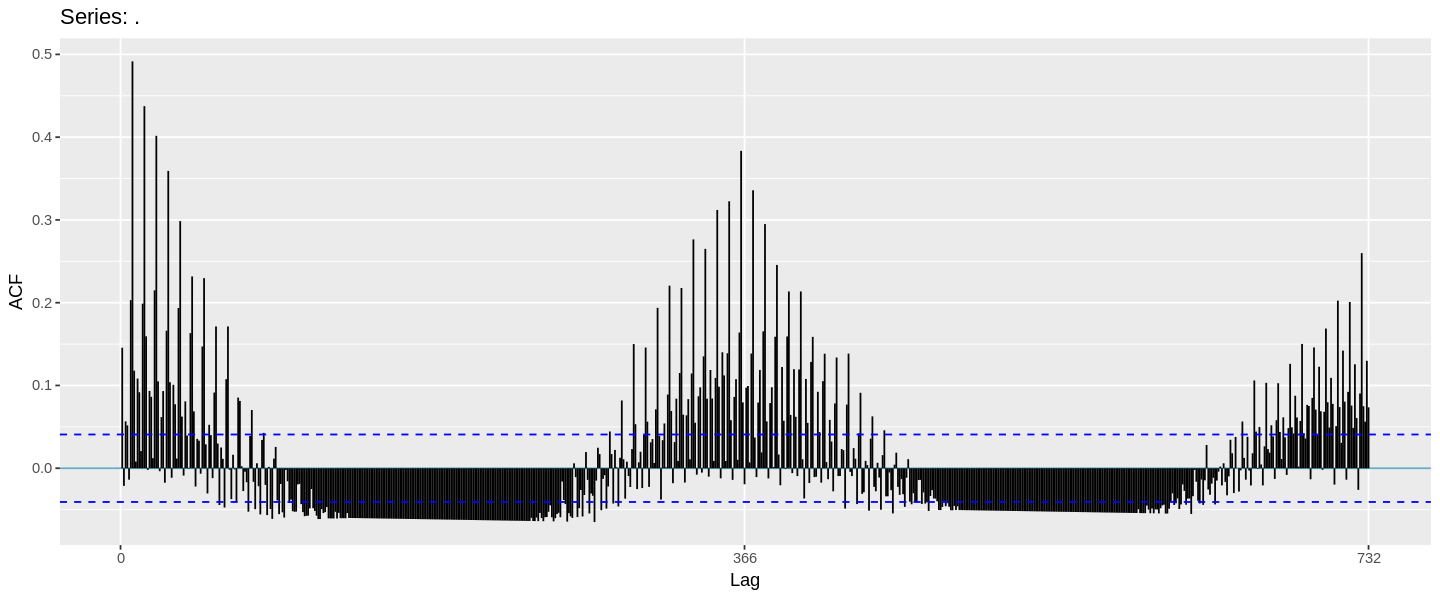

In [222]:
ts(ts_[,5], start = c(2007,05,29), frequency = 366) %>% zoo::na.fill(0) %>% ggAcf()

In [196]:
1461/365

[1] 4.00274

In [205]:
ggthemr::ggthemr_reset()

In [208]:
df_train

t_date     t_yr t_mo t_day t_qtr t_wk t_day_of_yr t_day_of_wk
1    2007-05-29 2007 5    29    2     22   149         2          
2    2007-05-29 2007 5    29    2     22   149         2          
3    2007-05-29 2007 5    29    2     22   149         2          
4    2007-05-29 2007 5    29    2     22   149         2          
5    2007-05-29 2007 5    29    2     22   149         2          
6    2007-05-29 2007 5    29    2     22   149         2          
7    2007-05-29 2007 5    29    2     22   149         2          
8    2007-05-29 2007 5    29    2     22   149         2          
9    2007-05-29 2007 5    29    2     22   149         2          
10   2007-05-29 2007 5    29    2     22   149         2          
11   2007-05-29 2007 5    29    2     22   149         2          
12   2007-05-29 2007 5    29    2     22   149         2          
13   2007-05-29 2007 5    29    2     22   149         2          
14   2007-05-29 2007 5    29    2     22   149         2          
15   2007-05-29 2007 5    29    2     22   149         2          
16   2007-05-29 2007 5    29    2     22   149         2          
17   2007-05-29 2007 5    29    2     22   149         2          
18   2007-05-29 2007 5    29    2     22   149         2          
19   2007-05-29 2007 5    29    2     22   149         2          
20   2007-06-05 2007 6     5    2     23   156         2          
21   2007-06-05 2007 6     5    2     23   156         2          
22   2007-06-05 2007 6     5    2     23   156         2          
23   2007-06-05 2007 6     5    2     23   156         2          
24   2007-06-05 2007 6     5    2     23   156         2          
25   2007-06-05 2007 6     5    2     23   156         2          
26   2007-06-05 2007 6     5    2     23   156         2          
27   2007-06-05 2007 6     5    2     23   156         2          
28   2007-06-05 2007 6     5    2     23   156         2          
29   2007-06-05 2007 6     5    2     23   156         2          
30   2007-06-05 2007 6     5    2     23   156         2          
⋮    ⋮          ⋮    ⋮    ⋮     ⋮     ⋮    ⋮           ⋮          
8193 2013-09-26 2013 9    26    3     39   269         4          
8194 2013-09-26 2013 9    26    3     39   269         4          
8195 2013-09-26 2013 9    26    3     39   269         4          
8196 2013-09-26 2013 9    26    3     39   269         4          
8197 2013-09-26 2013 9    26    3     39   269         4          
8198 2013-09-26 2013 9    26    3     39   269         4          
8199 2013-09-26 2013 9    26    3     39   269         4          
8200 2013-09-26 2013 9    26    3     39   269         4          
8201 2013-09-26 2013 9    26    3     39   269         4          
8202 2013-09-26 2013 9    26    3     39   269         4          
8203 2013-09-26 2013 9    26    3     39   269         4          
8204 2013-09-26 2013 9    26    3     39   269         4          
8205 2013-09-26 2013 9    26    3     39   269         4          
8206 2013-09-26 2013 9    26    3     39   269         4          
8207 2013-09-26 2013 9    26    3     39   269         4          
8208 2013-09-26 2013 9    26    3     39   269         4          
8209 2013-09-26 2013 9    26    3     39   269         4          
8210 2013-09-26 2013 9    26    3     39   269         4          
8211 2013-09-26 2013 9    26    3     39   269         4          
8212 2013-09-26 2013 9    26    3     39   269         4          
8213 2013-09-26 2013 9    26    3     39   269         4          
8214 2013-09-26 2013 9    26    3     39   269         4          
8215 2013-09-26 2013 9    26    3     39   269         4          
8216 2013-09-26 2013 9    26    3     39   269         4          
8217 2013-09-26 2013 9    26    3     39   269         4          
8218 2013-09-26 2013 9    26    3     39   269         4          
8219 2013-09-26 2013 9    26    3     39   269         4          
8220 2013-09-26 2013 9    26    3     39   269      

# Some graphs for the report

In [31]:
library("cowplot")

In [33]:
library("gridExtra")


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [107]:
options(repr.plot.width=10, repr.plot.height=5)
p1 = df_loc %>%
    filter(loc_community %in% sample(df_loc$loc_community %>% unique(),15)) %>%
    ggplot(aes(fill=mos_any_wnv_present,loc_community))+
    geom_bar(position = "fill") + coord_flip()+
    labs(x="Community",y="Percentage Mosquitos with WNV")+ 
    scale_y_continuous(labels = scales::percent)+
    theme(legend.position = "None")
p2 = df_train %>% 
    filter(zone_class %in% sample(df_train$zone_class %>% unique(),15)) %>%
    ggplot(aes(fill=mos_any_wnv_present,zone_class)) +
    geom_bar(position="fill")+
    theme(legend.position = "None") + coord_flip()+
    scale_y_continuous(labels = scales::percent)+
    labs(x="Zone Class", y="Percentage Mosquitos with WNV")
p3 = df_train %>% 
    filter(trap_trap_name %in% sample(df_train$trap_trap_name %>% unique(),15)) %>%
    ggplot(aes(fill=mos_any_wnv_present,trap_trap_name)) +
    geom_bar(position="fill")+
    theme(legend.position = "None") + coord_flip()+
    scale_y_continuous(labels = scales::percent)+
    labs(x="Trap Name", y="Percentage Mosquitos with WNV")
p4 = df_train %>% 
    filter(loc_zipcode %in% sample(df_train$loc_zipcode %>% unique(),15)) %>%
    ggplot(aes(fill=mos_any_wnv_present,loc_zipcode)) +
    geom_bar(position="fill")+
    theme(legend.position = "None") + coord_flip()+
    scale_y_continuous(labels = scales::percent)+
    labs(x="Zipcode", y="Percentage Mosquitos with WNV")

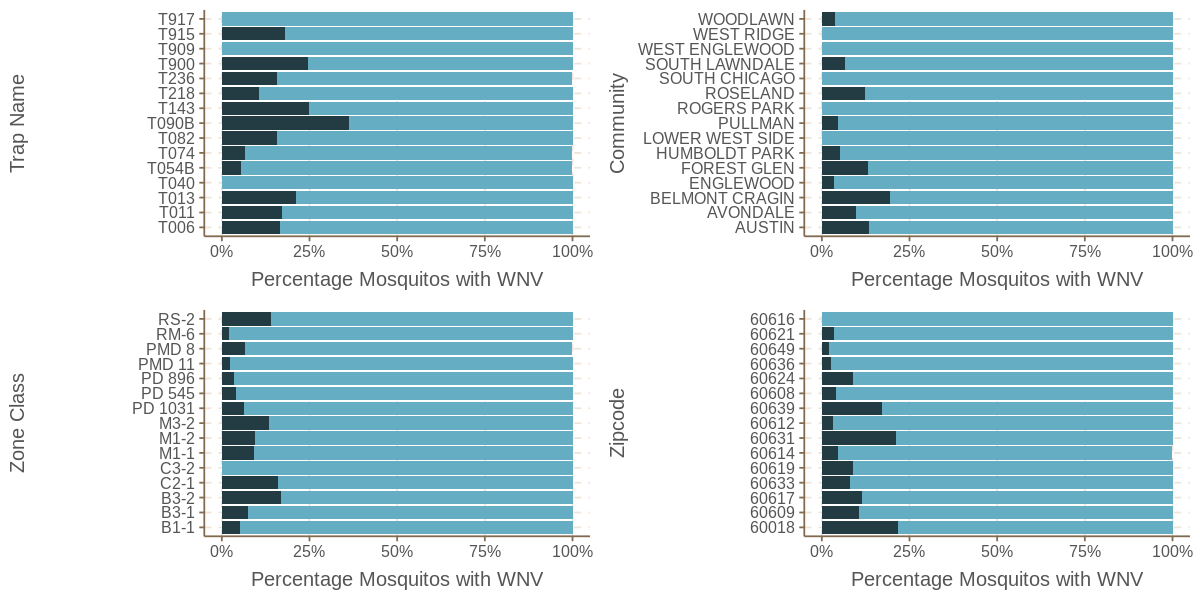

In [109]:
plot_grid(p3,p1,p2,p4, align = c("v","h"))

Parsed with column specification:
cols(
  date = col_character(),
  googtrend_sym_wnv = col_integer(),
  googtrend_deadbirds = col_integer(),
  googtrend_westnile = col_integer(),
  googtrend_mosq_bites = col_integer()
)


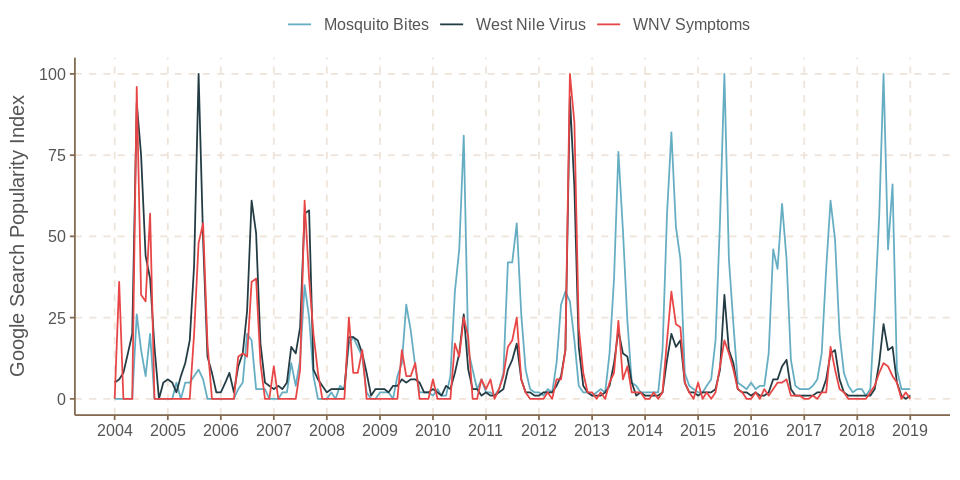

In [167]:
google_trends <- read_csv("../../data/processed/google_trends.csv")
google_trends$date <- lubridate::ymd(paste0(google_trends$date,"-01"))
google_trends$googtrend_deadbirds=NULL
names(google_trends) = c("date","WNV Symptoms","West Nile Virus","Mosquito Bites")#	googtrend_sym_wnv	googtrend_westnile	googtrend_mosq_bites
google_trends %>% gather(key,value,-date) %>%
    ggplot(aes(date,value,color=key)) +
    geom_line()+
    scale_x_date(date_breaks = "1 year",date_labels = "%Y")+
    theme(legend.position = "top") +
    labs(y="Google Search Popularity Index", x="",color="")

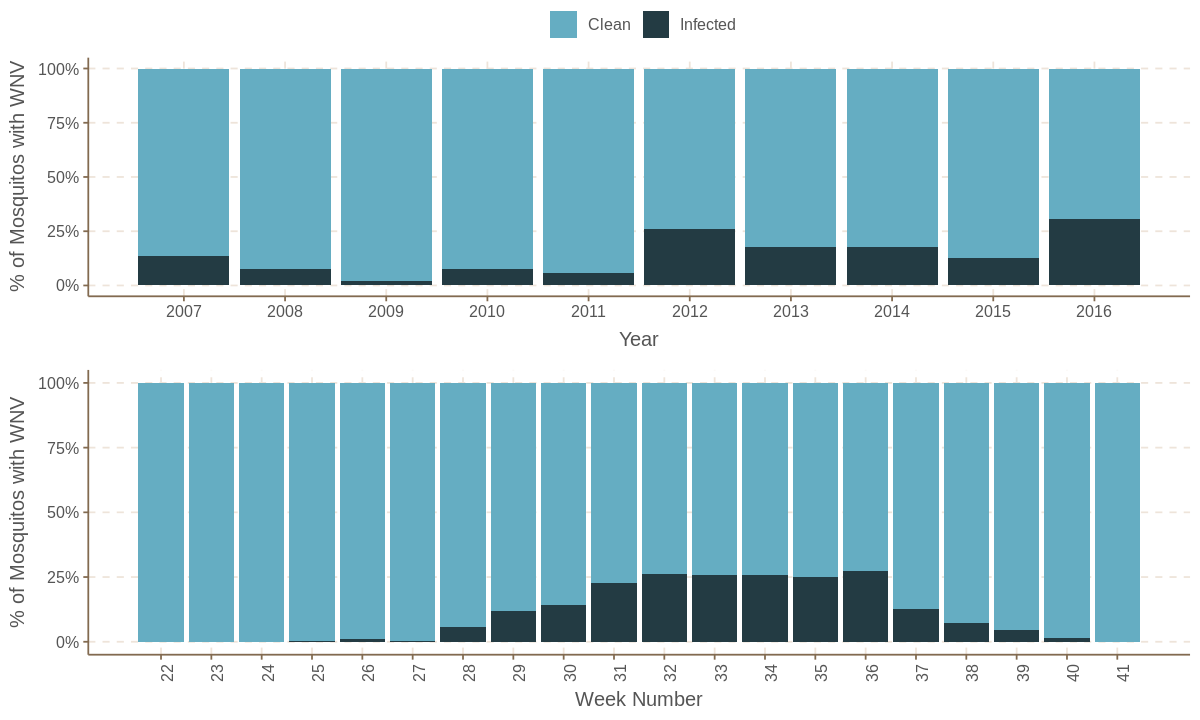

In [266]:
df_train %>% bind_rows(df_val) %>% 
    mutate(mos_any_wnv_present = factor(mos_any_wnv_present, levels = c(F,T),labels = c("Clean","Infected"))) %>%
    ggplot(aes(fill=mos_any_wnv_present,t_yr)) +
    geom_bar(position="fill")+theme(axis.text.x = element_text(angle=90))+
    theme(legend.position = "top",axis.text.x = element_text(angle = 0))+
    labs(x="Year", y="% of Mosquitos with WNV",fill="")+
    scale_x_continuous(breaks = 2007:2016)+
    scale_y_continuous(labels = scales::percent) -> p1

df_train %>% bind_rows(df_val) %>% ggplot(aes(fill=mos_any_wnv_present,t_wk)) +
    geom_bar(position="fill")+theme(axis.text.x = element_text(angle=90))+
    theme(legend.position = "None")+
    labs(x="Week Number", y="% of Mosquitos with WNV")+
    scale_x_continuous(breaks = 22:41)+
    scale_y_continuous(labels = scales::percent)->p2

options(repr.plot.width=10, repr.plot.height=6)
cowplot::plot_grid(p1,p2,ncol = 1)

In [268]:
df_train %>% dim

[1] 15257   118